# Initial work for larger MD relaxation

## Import Packages

In [1]:
#import sympy 
import numpy as np 
#from pprint import pprint
import matplotlib.pyplot as plt
from tqdm import trange
from numba import jit

In [2]:
# import time
# !pip install ipython-autotime #Install 
# %load_ext autotime

## Enter Google-Drive storage

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Colab Notebooks/MSE561/MSE561_Lab4Proj

/content/drive/MyDrive/Colab Notebooks/MSE561/MSE561_Lab4Proj


## Constants

In [5]:
K_B   = 8.617e-5   #eV/K
K_B_J = 1.38e-23   #J/K
m     = 6.63*1e-26 #kg

## Create intial 20*20 blocks (with random displacement)

In [6]:
def init_coords(n=20,rmin=3.405*(2**(1/6))):
    """Initialize a 2D array of coordinates with random displacement.

    This function generates a 2D array of coordinates on a regular grid, and adds a small random
    displacement to each coordinate. The grid is created with a specified minimum distance between
    the coordinates (rmin) and a specified number of points in each dimension (n).

    Args:
        rmin (float, optional): Minimum distance between coordinates. Defaults to 3.405*(2**(1/6)).
        n (int, optional): Number of points in each dimension of the grid. Defaults to 20.

    Returns:
        numpy.ndarray: A 2D array of shape (n * n, 2) containing the coordinates with random displacement.
    """
    # 20*20 regular array
    coords_init = np.array([[rmin*float(i), rmin*float(j)] for i in range (0,n) for j in range(0,n)])
    # random displacement, range as (-0.5,0.5)*1e-2
    coords_init += (np.random.random(np.shape(coords_init))-0.5)*1e-2
    return coords_init

Let's create an initial regular 20*20 block.

In [7]:
coords = init_coords(n=20)

## Define the optimisation functions & parameters

In [8]:
@jit 
def dist(a, b):
    """Calculate the Euclidean distance between two points. 

    Args:
        a (numpy.ndarray): An array representing the first point (x1, y1).
        b (numpy.ndarray): An array representing the second point (x2, y2).

    Returns:
        numpy.ndarray: The Euclidean distance between the two points.
    """
    return ((a[0] - b[0])**2 + (a[1] - b[1])**2)**0.5

The LJ potential could be approximately written as:

 $\phi(r) = \begin{cases} 4\epsilon  [(\frac{\sigma}{r})^{12} - (\frac{\sigma}{r})^{6}]  \qquad, r<r_0
\\
A(r-r_{cut})^3+B(r-r_{cut})^2   \qquad, r_{cut}\geq r\geq r_0
\\
0 \qquad, r>r_{cut}
\end{cases}  $


In [9]:
@jit
def LJ(r, A=-6.8102128e-3, B=-5.5640876e-3, R0=7.0, RCUT=7.5, EPSILON=0.010323, SIGMA = 3.405):  # r = distance from central atom
    """Calculate the LJ potential for a given distance.

    Args:
        r (numpy.ndarray): The distance between two atoms.
        A (float, optional): Constant parameter A of LJ potential function when (r_0 >r >rcut). Defaults to -6.8102128*10**-3.
        B (float, optional): Constant parameter B of LJ potential function when (r_0 >r >rcut). Defaults to -5.5640876*10**-3.
        R0 (float, optional): Distance threshold for the potential function. Defaults to 7.0.
        RCUT (float, optional): Cutoff distance for the potential function. Defaults to 7.5.
        EPSILON (float, optional): Depth of the potential well. Defaults to 0.010323.
        SIGMA (float, optional): Distance at which the potential is zero. Defaults to 3.405. 

    Returns:
        numpy.ndarray: The LJ potential for the given distance.
    """
    if r <= R0:
        return 4*EPSILON*( (SIGMA/r)**12 - (SIGMA/r)**6 )
    elif r<=RCUT:
        return A*(r-RCUT)**3+B*(r-RCUT)**2
    return 0

In [10]:
#we make a simple derivative of LJ 
@jit
def dLJ(r, A=-6.8102128e-3, B=-5.5640876e-3, R0=7.0, RCUT=7.5, EPSILON=0.010323, SIGMA = 3.405):  
    """Calculate the derivative of the LJ potential for a given distance.

    Args:
        r (numpy.ndarray): The distance between two atoms.
        A (float, optional): Constant parameter A of LJ potential function when (r_0 >r >rcut). Defaults to -6.8102128*10**-3.
        B (float, optional): Constant parameter B of LJ potential function when (r_0 >r >rcut). Defaults to -5.5640876*10**-3.
        R0 (float, optional): Distance threshold for the potential function. Defaults to 7.0.
        RCUT (float, optional): Cutoff distance for the potential function. Defaults to 7.5.
        EPSILON (float, optional): Depth of the potential well. Defaults to 0.010323.
        SIGMA (float, optional): Distance at which the potential is zero. Defaults to 3.405. 

    Returns:
        numpy.ndarray: The derivative of the LJ potential for the given distance.
    """
    if r <= R0:
        return 4*EPSILON*( -12.0/r *(SIGMA/r)**12 + 6.0/r *(SIGMA/r)**6 )
    if r <= RCUT:
        return 3*A*(r-RCUT)**2+2*B*(r-RCUT)
    return 0

In [11]:
@jit
def rdf(coords, RDF_MAX=12, n=400, RHO=400./((19*(3.405*(2**(1/6))))**2), PI=np.pi):
    """Calculate the radial distribution function (RDF) for a given set of atomic coordinates.

    Args:
        coords (numpy.ndarray): A 2D array containing the atomic coordinates.
        RDF_MAX (int, optional): Maximum distance to consider for the RDF calculation. Defaults to 12.
        n (int, optional): Number of atoms in the system. Defaults to 400.
        RHO (float, optional): Number density of the atomic system. Defaults to 400./((19*(3.405*(2**(1/6))))**2).
        PI (float, optional): The value of pi. Defaults to np.pi.

    Returns:
        tuple: A tuple includes a ndarray of radial distances (r) and the corresponding RDF values.
    """
    r = np.linspace(1,RDF_MAX,n)
    rdf_result = []
    dr = 0.1
    for r_value in r:
        count = 0   
        for i in range(n):
            for j in range(n):
                if i!=j:
                    if r_value <= dist(coords[i],coords[j]) <= r_value+dr :
                        count += 1
        rdf_result.append(count/(2*PI*r_value*dr*n*RHO))
    return r, rdf_result

In [12]:
@jit
def force(target,coords,RCUT=7.5,n=400):  
    """Computes the force acting on a target atom in a 2D system of atoms.

    The force is calculated by summing the LJ potential forces 
    between the target atom and all other atoms within the specified cutoff distance.

    Args:
        target (int): Index of the target atom, i.e., coords[target] would give the coordinates (x, y).
        coords (numpy.ndarray): ndarray of all atoms' positions, shape: (n, 2).
        RCUT (float, optional): Cutoff distance for the LJ potential calculation. Defaults to 7.5.
        n (int, optional): Total number of atoms in the system. Defaults to 400.

    Returns:
        numpy.ndarray: The net force acting on the target atom, shape: (2,), where the first element is the x-component and the second element is the y-component.
    """
    F = np.zeros(2)  # force_x,force_y = 0,0

    for i in range(n):  # sum forces over neighbors within potential cutoff
        d = dist(coords[target], coords[i])
        if i != target and d <= RCUT:
            r = coords[i] - coords[target]  # r[0],r[1] = x,y
            F += dLJ(d) / d * r

    return F

In [13]:
@jit
def E_p(coords,n=400):
    """Calculate the potential energy of the system for a given set of atomic coordinates.

    Args:
        coords (numpy.ndarray): A 2D array containing the atomic coordinates.
        n (int, optional): Number of atoms in the system. Defaults to 400.

    Returns:
        float: The potential energy of the system.
    """
    # initialze energy
    potential = 0
    for i in range(n):
        for j in range(i+1,n):
            d = dist(coords[i],coords[j])
            # equilibrium thus E(xy)=E(yx), and E(xx) and E(yy) did not be count on for now
            potential += LJ(d) 
    return potential

In [14]:
### get the central atom stress components
@jit
def stress(center, coords, n=20, rmin=3.405*(2**(1/6)), rcut=7.5):  
    """Calculate the stress components of a central atom in a system of atoms.

    Args:
        center (int): The index of the central atom in the coords array.
        coords (numpy.ndarray): A 2D array containing the atomic coordinates.
        n (int, optional): The number of atoms in each column. Defaults to 20.
        rmin (float, optional): Minimum distance between atoms. Defaults to 3.405*(2**(1/6)).<---------------------
        rcut (float, optional): Cutoff distance for stress calculation. Defaults to 7.5.

    Returns:
        numpy.ndarray: A 1D array containing the stress components (xx, xy, yx, yy) of the central atom.
    """
    AREA = (n-1)*3.405*rmin**2
    atom_num = n**2
    
    # stress xx,xy,yx,yy are s[0,0] [0,1] [1,0] [1,1] respectively
    s = np.zeros(4)

    for i in range(atom_num):
        d = dist(coords[i],coords[center])
        if i!=center and d<=rcut:

            #clarify what are these steps in relation to the formulae
            x = coords[i][0] - coords[center][0]
            y = coords[i][1] - coords[center][1]
            
            delta_matrix = np.array([x**2,x*y,y*x,y**2])
            s += delta_matrix *dLJ(d)/d

    s /= (AREA/atom_num)
    return s

In [15]:
@jit
def stress_total(coords,n=20):
    """Calculate the total stress components of a system of atoms.

    Args:
        coords (numpy.ndarray): A 2D array containing the atomic coordinates.
        n (int, optional): The number of atoms in each column. Defaults to 20.

    Returns:
        numpy.ndarray: A 1D array containing the total stress components (xx, xy, yx, yy) of the system.
    """
    atom_num = n**2
    stress_tot = np.array([0.,0.,0.,0.])
    
    # sum up 
    for i in range(atom_num):
        stress_tot += stress(i,coords)
    return stress_tot

In [16]:
# Hydrostatic stress for each single atom
@jit
def stress_h(center,coords,n=20,rmin=3.405*(2**(1/6)),rcut=7.5):
    """Calculate the hydrostatic stress of a single atom in a system of atoms.

    Args:
        center (int): The index of the center atom in the coords array.
        coords (numpy.ndarray): A 2D array containing the atomic coordinates.
        n (int, optional): The number of atoms in each column. Defaults to 20.
        rmin (float, optional): Minimum distance between atoms, essentially it is the distance of one atom's nearest neighbour. Defaults to 3.405*(2**(1/6)).<---------------------
        rcut (float, optional): Cutoff distance for stress calculation. Defaults to 7.5.

    Returns:
        float: The hydrostatic stress of the single atom.
    """
    AREA = ((n-1)*rmin)**2
    atom_num = n**2

    # stress xx,yy are s[0],s[1] respectively
    s = np.zeros(2)

    for i in range(atom_num):
        d = dist(coords[i],coords[center])
        if i!=center and d<=rcut:
            r = coords[i] - coords[center]
            delta_matrix = np.array([r[0]**2,r[1]**2])
            s += delta_matrix *dLJ(d)/d

    s /= (AREA/atom_num)

    stress_hs = - 0.5 * sum(s) # only the hydrostatic pressure is needed
    
    return stress_hs

In [17]:
# Total Hydrostatic stress for 20*20 block
@jit
def total_hydrostatic_stress(coords,n=20):
    """Calculate the total hydrostatic stress for a block of atoms.

    Args:
        coords (numpy.ndarray): A 2D array containing the x and y coordinates of atoms in the block.
        n (int, optional): The number of atoms for each column. Defaults to 20.

    Returns:
        numpy.ndarray: The total hydrostatic stress for the block.
    """
    sigma_h_tot = 0
    atom_num = n**2
    for i in range(atom_num):
        sigma_h_tot += stress_h(i,coords)
    return sigma_h_tot

In [18]:
total_hydrostatic_stress(coords)

-0.7415027241518289

In [19]:
@jit
def E_k(v_J, m=6.63*1e-26):
    """Calculate the kinetic energy of a system of atoms.

    Args:
        v_J (numpy.ndarray): Velocities of atoms at a certain timestep, angstrom/s, (400,2)
        m (float, optional): The mass of one single Argon atom. Defaults to 6.63*1e-26, kg

    Returns:
        float: The total kinetic energy of the system.
    """
    vv = v_J.flatten()
    # 1Å²*kg/s² =0.0624eV, 0.5*m*sum(vv**2) is of Å²*kg which should be turn into eV
    return 0.5*m*sum(vv**2)*0.0624

In [20]:
@jit
def temperature(v_J, N=400, K_B=8.67*1e-5):
    """Calculate the temperature of a system of atoms.

    Args:
        v_J (numpy.ndarray): A 2D array containing the velocities of atoms in the system. <---------------------
        N (int, optional): The total number of atoms in the system. Defaults to 400.
        K_B (float, optional): Boltzmann's constant in eV/K. Defaults to 8.67*1e-5.

    Returns:
        float: The temperature of the system.
    """
    E_kin = E_k(v_J)
    return E_kin/(N*K_B)

In [21]:
@jit
def force_arr(coords):
    """Calculate the force acting on each atom in the system.

    Args:
        coords (numpy.ndarray): A 2D array containing the x and y coordinates of atoms in the system.

    Returns:
        numpy.ndarray: A 2D array containing the force acting on each atom, eV/angstrom
    """
    f = np.zeros(np.shape(coords))
    for a in range(len(f)):
        f[a] = force(a,coords)
    return f

## Define Plotting Functions

#### Plot Block

In [22]:
def plot_block(coords,stopstep,T_init=None):
    """Plot the block of atoms with their coordinates.

    Args:
        coords (numpy.ndarray): A 2D array containing the x and y coordinates of atoms in the block.
        stopstep (int): The iteration number at which the simulation stopped.
        T_init(int or float): T_desire of the system. Just for plot's title. (Defaults to 'None')
    """
    n=int((len(coords)**0.5))
    if T_init == None:
        TITLE='Initial '+str(n)+'*'+str(n)+' Block'
    elif stopstep==0:
        TITLE='Initial '+str(n)+'*'+str(n)+' Block at '+str(T_init)+'K'
    else:
        TITLE='MD-'+str(T_init)+'K relaxed '+str(n)+'*'+str(n)+' Block, iter='+str(stopstep)
    plt.figure(figsize=(4,4))
    x = [i[0] for i in coords]
    y = [i[1] for i in coords]
    plt.scatter(x,y,s=8)
    plt.xlabel('x coordinate')
    plt.ylabel('y coordinate')
    plt.title(TITLE)
    plt.show()

#### RDF

In [23]:
def plot_rdf(coords,title='Initial RDF'):
    """Plot the radial distribution function (RDF) of the system.

    Args:
        coords (numpy.ndarray): A 2D array containing the x and y coordinates of atoms in the system.
        title (str, optional): The title for the plot. Defaults to 'Initial RDF'.
    """
    r,rdf_result=rdf(coords)
    rdf_result = list(rdf_result)
    print('length of r array')
    print(len(r))
    print('begining and end of r array')
    print(r[0],r[-1])
    plt.figure(figsize=(8,5))
    plt.bar(r,rdf_result,width=0.2)
    plt.xlim((2,13))
    plt.title(title)
    plt.xlabel('Distance (Å)')
    plt.ylabel('Radial distribution function [# atoms]')
    plt.show()

length of r array
400
begining and end of r array
1.0 12.0


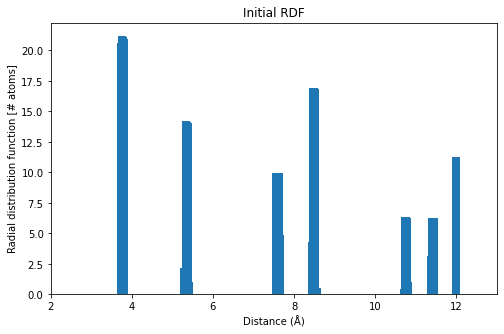

In [24]:
c = init_coords(rmin=3.405*(2**(1/6)))
plot_rdf(c,title='Initial RDF')

#### Potential&Kinetic Energy Evolution

In [25]:
def Plot_Ep_Ek(E_p,E_k,stopstep,T_init=None):
    """Plot the potential, kinetic, and total energies of the system versus the number of iterations.

    Args:
        E_p (list): A list of potential energies at each iteration.
        E_k (list): A list of kinetic energies at each iteration.
        stopstep (int): The iteration number at which the simulation stopped.
        T_init (float, optional): The initial temperature of the system. Defaults to None.
    """
    xlist = []
    for i in range(stopstep+1):
        if i%50 ==0:
            xlist.append(i)
        if len(xlist)==len(E_p):
            break
    E_tot = np.array(E_p)+np.array(E_k)
    plt.figure(figsize=(7,5))
    plt.plot([i for i in xlist], [i for i in E_p],label='Potential Energy')
    plt.plot([i for i in xlist], [i for i in E_k],label='Kinetic Energy')
    plt.plot([i for i in xlist], [i for i in E_tot],label='Total Energy')
    if T_init !=None:
        plt.title('Total energy versus iters, T='+str(T_init)+'K')
    else:
        plt.title('Total energy versus iters') 
    plt.xlabel('Iteration')
    plt.ylabel('Total Energy (eV)')
    plt.legend()
    plt.show()

#### Temperature versus iterations

In [26]:
def Plot_temperature(stopstep,T,T_init=None):
    """Plot the temperature of the system versus the number of iterations.

    Args:
        stopstep (int): The iteration number at which the simulation stopped.
        T (list): Temperature list appended and collected in main loop.
        T_init (float, optional): The initial temperature (T_desired) of the system. Defaults to None.
    """
    xlist = []
    for i in range(stopstep+1):
        if i%200 ==0:
            xlist.append(i)
        if len(xlist)==len(T):
            break
    plt.figure(figsize=(7,5))
    if T_init !=None:
        plt.title('Temperature versus iters, T_init='+str(T_init)+'K')
    else:
        plt.title('Temperature versus iters')
    plt.xlabel('Iterations')
    plt.ylabel('Temperature (K)')
    plt.plot([i for i in xlist], [i for i in T])
    plt.show()

#### Total Hydrostatic Pressure versus Iterations

In [27]:
def Plot_HS_tot(stopstep,hydrostress,T_init=None):
    """Plot the total hydrostatic stress versus the number of iterations.

    Args:
        stopstep (int): The iteration number at which the simulation stopped.
        hydrostress (list): A list of total hydrostatic stress values at each iteration.
        T_init (float, optional): The initial temperature of the system. Defaults to None.
    """
    xlist = []
    for i in range(stopstep+1):
        if i%200 ==0:
            xlist.append(i)
        if len(xlist)==len(hydrostress):
            break
    plt.figure(figsize=(7,5))
    if T_init !=None:
        plt.title('Hydrostatic Pressure versus Iters, T='+str(T_init)+'K')
    else:
        plt.title('Hydrostatic Pressure versus Iters')
    plt.xlabel('Iteration')
    plt.ylabel('Stress (eV/Å²)')
    plt.plot([i for i in xlist], [i for i in hydrostress])
    plt.show()

#### Hydrostatic Pressure of atoms

In [28]:
@jit
def sigma_h(coords):
    """Calculate the hydrostatic stress for each atom in the system.

    Args:
        coords (numpy.ndarray): A 2D array containing the x and y coordinates of atoms in the system.

    Returns:
        numpy.ndarray: A 1D array containing the hydrostatic stress values for each atom.
    """
    hs = np.zeros(len(coords))
    for i in range(400):
        hs[i] = stress_h(i,coords)
    return hs

In [29]:
def Plot_sigma_h(coords,T_init,Type='MD'):
    """Plot the hydrostatic stress distribution in the final atomic structure.

    Args:
        coords (numpy.ndarray): A 2D array containing the x and y coordinates of atoms in the system.
        T_init (float): The initial temperature of the system.
        Type (str, optional): The type of simulation used to generate the structure (e.g., 'MD' for molecular dynamics). Defaults to 'MD'.
    """
    coords_list = []
    for i in range(len(coords)):
        coords_list.append(list(coords[i]))
    plt.figure(figsize=(6.5,5))
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.title('Hydrostatic stress, '+str(Type)+'final structure at '+str(T_init)+'K')
    plt.scatter([i[0] for i in coords_list],[i[1] for i in coords_list],s=8,c=sigma_h(coords))
    plt.colorbar(label='eV/Å²')
    plt.show()

## Define Plotting MD's all Results

In [30]:
def Plot_results(coords,E_p,E_k,hydrostress,T,T_init,stopstep):
    """Plot various results of the atomic simulation, including relaxed block structure, energies, RDF, temperature, and hydrostatic stress.

    Args:
        coords (numpy.ndarray): A 2D array containing the x and y coordinates of atoms in the system.
        E_p (list): A list of potential energies at each iteration.
        E_k (list): A list of kinetic energies at each iteration.
        hydrostress (list): A list of total hydrostatic stress values at each iteration.
        T (list): A list of temperatures at each iteration.
        T_init (float): The initial temperature of the system.
        stopstep (int): The iteration number at which the simulation stopped.
    """
    
    plot_block(coords,stopstep,T_init)

    Plot_Ep_Ek(E_p,E_k,stopstep,T_init)

    plot_rdf(coords,title='MD-'+str(T_init)+'K relaxed RDF')

    Plot_temperature(stopstep,T,T_init)
    
    Plot_HS_tot(stopstep,hydrostress,T_init)
    
    Plot_sigma_h(coords,T_init)

# Carry out a MS relaxation for a 20x20 lattice

### Show initial block configuration

In [31]:
coords_MS = init_coords(n=20)

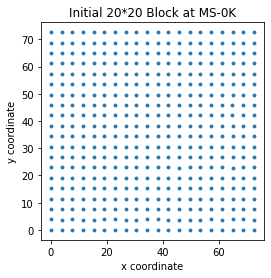

In [32]:
plot_block(coords_MS,0,'MS-0')

### State the boundary conditions

2D finite non-periodic boundary condition with four free surfaces

### Run Molecular Statics Iterations

In [33]:
LAMBDA = 1.2

coords_MS = coords.copy()

E_tot_MS=[]
max_force_MS=[]
stress_tot_MS = [] # same as xx,xy,yx,yy = [],[],[],[]

iter_num = 50000

for i in trange(iter_num+1):
    
    # get the force array, force_coords.shape() = (400,2)
    # F_x_atom,F_y_atom = force_coords[a]
    force_coords = force_arr(coords_MS)

    # get resultant force, resultant_force.shape = (400,1)
    resultant_force=np.sum((force_coords)**2,axis=1)**0.5
        
    # △r_x and △r_y are delta[a][0] and delta[a][1], respectively
    delta = LAMBDA *force_coords

    #update atom position
    #coords[a][0] and [a][1] += delta[0] and [1], respectively
    coords_MS += delta
        
    E_tot_MS.append(E_p(coords_MS))
    max_force_MS.append(np.max(resultant_force))

    if (i%100==0):
        stress_tot_MS.append(list(stress_total(coords_MS)))


100%|██████████| 50001/50001 [01:35<00:00, 524.35it/s]


** **
### ! **Save MS relaxed data**

If you are the first time constructing data after MS relaxation, please remember **DOWNLOAD** the ***.npy*** files.

If you are **re-loading** previously saved after-relaxed data, please only run this part and **afterwards**.

**DO NOT RUN AGAIN the relaxation procedures written before.**

In [34]:
np.save('MS_relaxed_coords',coords_MS)
np.save('MS_relaxed_E_tot',E_tot_MS)
np.save('MS_iter_num',iter_num)

In [35]:
coords_MS = np.load('MS_relaxed_coords.npy')
E_tot_MS = np.load('MS_relaxed_E_tot.npy')
iter_num = np.load('MS_iter_num.npy')

** **

### Plot the relaxed structure

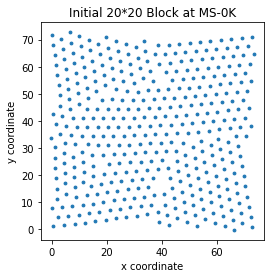

In [36]:
plot_block(coords_MS,stopstep=0,T_init='MS-0')

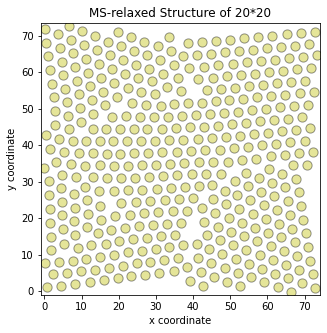

In [37]:
plt.figure(figsize=(5,5)).tight_layout()
x = [i[0] for i in coords_MS]
y = [i[1] for i in coords_MS]
plt.scatter(x,y,s=85,color='y',alpha=0.4,edgecolors='black',linewidth=1)
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.title('MS-relaxed Structure of 20*20')
plt.margins(x=0.01,y=0.01)
plt.show()

### Plot radial distribution function (RDF) of MS

For Molecular Statics simulation, defaulted temperature is T=0K

length of r array
400
begining and end of r array
1.0 12.0


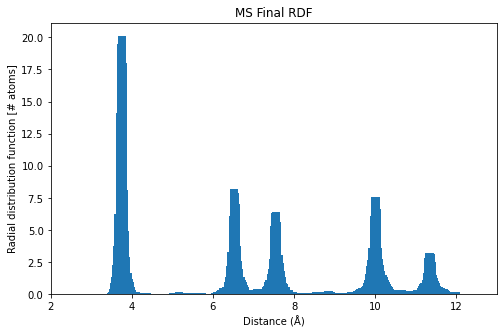

In [38]:
plot_rdf(coords_MS,title='MS Final RDF')

### Plot the total energy and the hydrostatic pressure

To examine whether the MS iterations achieve physicalogical convergence, we should check **Total Energy**, **MaxForce**, and **Hydrostatic Pressure**.

#### Total Energy

Text(0, 0.5, 'Total Energy (eV)')

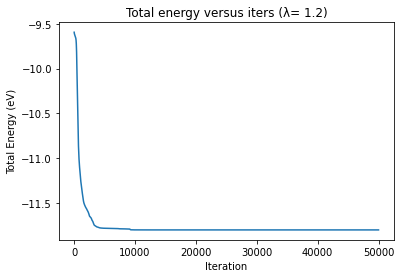

In [39]:
plt.plot(E_tot_MS)
plt.title('Total energy versus iters (λ= 1.2)')
plt.xlabel('Iteration')
plt.ylabel('Total Energy (eV)')

#### Max Force

Text(0, 0.5, 'Max force (eV//Å)')

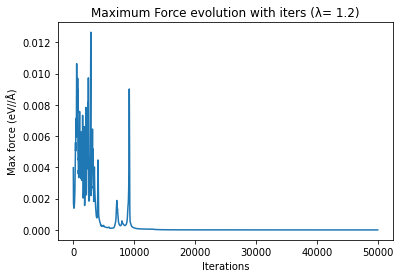

In [40]:
plt.plot(max_force_MS)
plt.title('Maximum Force evolution with iters (λ= '+str(LAMBDA)+')')
plt.xlabel('Iterations')
plt.ylabel('Max force (eV//Å)')

#### Total Stress Tensor

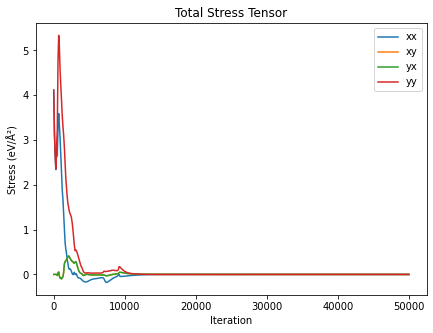

In [41]:
xlist = []

for i in range(iter_num+1):
    if i%100 ==0:
        xlist.append(i)
plt.figure(figsize=(7,5))
plt.xlabel('Iteration')
plt.ylabel('Stress (eV/Å²)')
plt.plot([i for i in xlist], [i[0] for i in stress_tot_MS], label='xx')
plt.plot([i for i in xlist], [i[1] for i in stress_tot_MS], label='xy')
plt.plot([i for i in xlist], [i[2] for i in stress_tot_MS], label='yx')
plt.plot([i for i in xlist], [i[3] for i in stress_tot_MS], label='yy')
plt.legend()
plt.title('Total Stress Tensor')
plt.show()

#### Hydrostatic Pressure

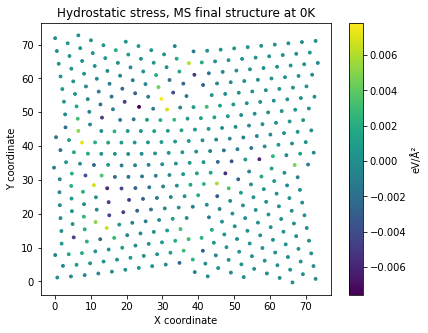

In [42]:
Plot_sigma_h(coords_MS,T_init=0,Type='MS ')

# **MD calculations beginning with a square 20x20 lattice**

#### Update loops

**Firstly, we need an velocity updating function.**

For the $i^{th}$ atom at $J^{th}$ timestep, the velocity array $\textbf{v}_i$ :
$$
\textbf{v}_i(t+\Delta t) = \textbf{v}_i(t) + \frac{\Delta t}{2m} (\textbf{F}_i((t+\Delta t)+\textbf{F}_i(t))
$$
Vecotorizing the velocity $\textbf{v}$ and force $\textbf{F}$ of whole 20*20 block, we have:
$$
\textbf{v}((J+1)\Delta t) = \textbf{v}(J\Delta t) + \frac{\Delta t}{2m} (\textbf{F}((J+1)\Delta t)+\textbf{F}(J\Delta t))
$$

In [43]:
@jit
def update_velocity_vectorize(force_J,force_J_1,v_J,delta_t,m=6.63*1e-26):
    """The update function for each atom's velocity
    Formula:
    v_i(J+1) = v_i(J) + (dt/2m)*(F_i(J+1)+F_i(J))

    Args:
        force_J (numpy.ndarray): Force array of previous timestep, eV/angstrom, (400,2)
        force_J_1 (numpy.ndarray): Force array of current timestep, eV/angstrom, (400,2)
        v_J (numpy.ndarray): Velocity array of previous timestep, (400,2)
        delta_t (float): Timestep, second(s).
        m (float, optional): Atomic mass, kg. Defaults to 6.63*1e-26.

    Returns:
        numpy.ndarray: Atomic velocity of next timestep, angstrom/s, (400,2) 
    """
    delta_v = delta_t/(2*m) * (force_J + force_J_1)
    v_J += delta_v*16.02   # eV*s/(Å*kg) to Å/s, 1eV*s/(Å*kg) =16.02Å/s

    return v_J

**Then, we update position(coordinate) array.**

For the $i^{th}$ atom in the block, its coordinate after one timestep $\textbf{r}_i(t+\Delta t)$ can be updated from $\textbf{r}_i(t)$ follows the equation:
$$
\textbf{r}_i(t+\Delta t) = \textbf{r}_i(t) +\textbf{v}_i(t){\Delta t} +\frac{(\Delta t)^2}{2m_i}\textbf{F}_i(t)
$$
For the $J^{th}$ timestep, the position array $\textbf{v}$ of whole 20*20 block :
$$
\textbf{r}_i((J+1)\Delta t) = \textbf{r}_i(J\Delta t) +\textbf{v}_i(J\Delta t){\Delta t} +\frac{(\Delta t)^2}{2m_i}\textbf{F}_i(J\Delta t)
$$

In [44]:
@jit
def update_position_vectorize(coords_J,force_J,v_J,delta_t,m=6.63*1e-26):
    """The update function for each atom's coordinate

    Args:
        coords_J (numpy.ndarray): Atomic positions of current timestep, angstrom, (400,2)
        force_J (numpy.ndarray): Force array of previous timestep, eV/angstrom, (400,2)
        v_J (numpy.ndarray): Velocity array of previous timestep, angstrom/s, angstrom/s, (400,2)
        delta_t (float): timestep, second(s)
        m (float, optional): Atomic mass, kg. Defaults to 6.63*1e-26.

    Returns:
        numpy.ndarray: Atomic positions of next timestep, angstrom, (400,2) 
    """
    # eV*s²/(Å*kg) to Å, 1eV*s²/(Å*kg) =16.02Å
    delta_r = v_J *delta_t + (delta_t**2/(2*m))*force_J*16.02
    coords_J_1 = coords_J + delta_r
    return coords_J_1

#### Functions for rescale

To maintain a constant temperature during the molecular dynamics (MD) procedure, we should manually implement a thermostat. The simplest method involves multiplying the temperature by a ratio, which allows it to remain consistently close to the desired temperature with an acceptable level of fluctuation. 

The definition of the scaling factor $\kappa$ is: 
$$
 { \kappa = [ \frac{3Nk_{B}T}{\sum_{i=1}^N m_i<v_{i}^{2}>} ]^{\frac{1}{2}} } 
$$
where the T is the desired temperature.

Then, for observing the temperature flucturing, we have a simpler form of the real-time $\kappa$:
$$
{ \kappa = |\frac{T_{desire}}{T_{now}}|^{\frac{1}{2}}  }$$

In [45]:
@jit
def kappa(T_wanted,T_now):
    """Scaling parameter kappa

    Args:
        T_wanted (float): The desired ambient temperature we set, scalar
        T_now (float): The real time temperature, scalar

    Returns:
        float: Rescaling parameter kappa, scalar
    """
    return (T_wanted/T_now)**0.5

In [46]:
@jit
def v_new(v_J,kk):
    """To carry out velocity scaling

    Args:
        v_J (numpy.ndarray): current velocity of 400 atoms, (400,2)
        kk (float): current kappa value

    Returns:
        array: the already rescaled velocity array, (400,2)
    """
    return v_J*kk

In [47]:
def total_velocity(v):
    """To calculate a total velocity of the system

    Args:
        v (numpy.ndarray): velocity array of 400 atoms, (400,2)

    Returns:
        float: the total velocity of all 400 atoms
    """
    return sum(v.flatten())

#### Initialize atom positions

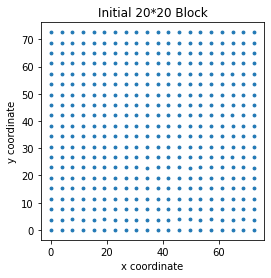

In [48]:
coords_MD = coords.copy()
plot_block(coords_MD,0)

#### Initialize atom velocities

In [49]:
v = np.zeros(np.shape(coords))  # initialize velocity array

### Main Loop (Verlet Algorithm)

The mainloop follows Verlet Algorithm.

In [50]:
def main_loop(coords, iter_num=100000, delta_t=1e-14, m=6.63*1e-26, K_B=8.67*1e-5, E_kin=0, T_init=0, tolerance_kappa=2e-4, tolerance_T=2):
    """The mainloop follows Verlet Algorithm.

    Args:
        coords (numpy.ndarray): input(initial) atoms' positions, angstrom, (400,2)
        iter_num (int, optional): Number of iterations. Defaults to 100000.
        delta_t (float, optional): Time step, second(s). Defaults to 1e-14.
        m (float, optional): Mass of Argon atom, kg. Defaults to 6.63*1e-26.
        K_B (float, optional): Boltzmann Constant, eV/K. Defaults to 8.67*1e-5.
        E_kin (int, optional): System kinetic energy, eV. Defaults to 0.
        T_init (int, optional): Desired Temperature, K. Defaults to 0.
        tolerance_T (float, optional): Temperature threshold triggering rescaling,Kelvin(K). Defaults to 1.5.

    Returns:
        coords_J_1 (numpy.ndarray): Output(resulting) atoms' positions, angstrom, (400,2)
        E_p_verlet (list): Potential energy recorded every 50 timesteps, eV
        E_k_verlet (list): Kinetic energy recorded every 50 timesteps, eV
        hydrostress_verlet (list): Total hydrostatic stree of 400 atoms system, eV/(angstrom^2)
        v_J (numpy.ndarray): Output(resulting) velocities of of 400 atoms, angstrom/(s^2), (400,2)
        T (list): Real-time temperature recorded every 200 timesteps, kelvin
        iter (int): The resulting iteration number, scalar
    """
    
    atom_num=len(coords)
    T_initial = T_init
    
    # Initialize lists for plotting
    E_p_verlet, E_k_verlet, hydrostress_verlet, T =[],[],[],[]

    # Initialize variable for optimising
    # Initial velocity array, all zeros
    v = np.zeros(np.shape(coords))  
    # Initial position(400,2), vector(400,2) and systemforce(1,2)
    coords_J_1 = coords.copy()
    v_J_1 = v.copy()
    force_J_1 = force_arr(coords_J_1)


    for iter in trange(iter_num+1):

        coords_J = coords_J_1.copy()  # positions of 400 atoms at JΔt
        force_J = force_J_1.copy()  # forces of of 400 atoms at JΔt, eV/angstrom
        v_J = v_J_1  # velocities of of 400 atoms at JΔt

        # Plot intermedium relaxed structures
        if iter in [0,1000,2000,4000,8000,20000,50000,75000,100000,130000,200000]:
            plot_block(coords_J,iter,T_initial)

        # Update the position array, coords_J.shape=(400,2), force_J.shape=(1,2)
        # According to r_i(J+1) = r_i(J) + (dt/2m)*(F_i(J+1)+F_i(J))
        coords_J_1 = update_position_vectorize(coords_J,force_J,v_J,delta_t,m=6.63*1e-26)

        # Update the force array, force_J.shape=(1,2)
        force_J_1 = force_arr(coords_J_1)

        # Update the velocity array, v.shape=(400,2), v_i.shape=(1,2)
        # According to v_i(J+1) = v_i(J) + (dt/2m)*(F_i(J+1)+F_i(J))
        v_J_1 = update_velocity_vectorize(force_J,force_J_1,v_J,delta_t,m=6.63*1e-26)

        
        # Rescale the velocity
        # Check convergency on temperature
        if (iter>=5000) and iter%5000 == 0:

            # If kappa is around 1, stop the main loop
            T_now = temperature(v_J_1)
            T_previous = temperature(v_J)
            if T_init == 0:
                kk=0
            else:
                kk=kappa(T_initial,T_now)
            if np.absolute(kk-1) <= tolerance_kappa:
                return coords_J_1, E_p_verlet, E_k_verlet, hydrostress_verlet, v_J, T, iter
            
            # Check whether rescale is needed
            delta_T = np.absolute(T_now-T_previous)
            if delta_T <= tolerance_T:
                v_J_1 = v_new(v_J_1,kk)



        #Calculate Energy, hydrostatic pressure
        #You can do this at every tens or hundreds of iterations

        if (iter%50==0):
            E_p_i,E_k_i = 0,0
            E_p_i += E_p(coords_J_1)
            E_k_i += E_k(v_J_1)
            E_p_verlet.append(E_p_i)
            E_k_verlet.append(E_k_i)

        if (iter%200==0):
            hydrostress_verlet.append(total_hydrostatic_stress(coords_J_1))
            T.append(temperature(v_J))
    


    return coords_J_1, E_p_verlet, E_k_verlet, hydrostress_verlet, v_J, T, iter
    


## 1.  MD calculation at 0K
#### *As you approach equilibrium the kinetic energy will become finite.*
#### *Stop the calculation, set the kinetic energy, i.e. velocities, again to zero and continue the MD calculation again. (Rescaling)*

### Set the threshold of rescaling
#### *Repeat this until the kinetic energy is small but not zero, corresponding, say to 1–2 degrees K.*

In [51]:
tolerance_T_0K=1

### Run MD at desire temperature of 0K

  0%|          | 0/100001 [00:00<?, ?it/s]

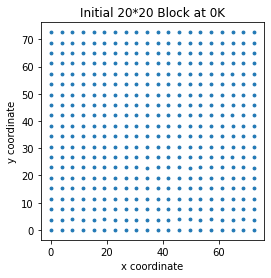

  0%|          | 175/100001 [00:01<10:02, 165.58it/s]

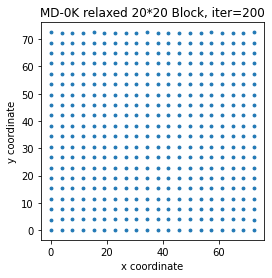

  0%|          | 496/100001 [00:02<03:35, 462.66it/s]

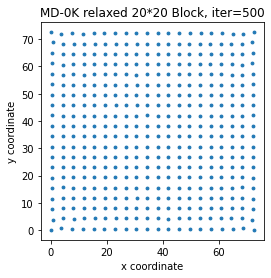

  1%|          | 967/100001 [00:03<02:28, 667.05it/s]

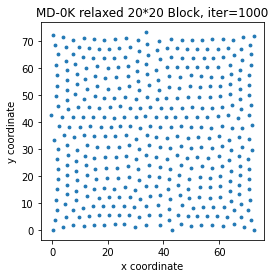

  2%|▏         | 1991/100001 [00:04<02:18, 706.67it/s]

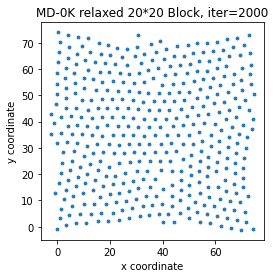

  4%|▍         | 3940/100001 [00:07<02:09, 743.91it/s]

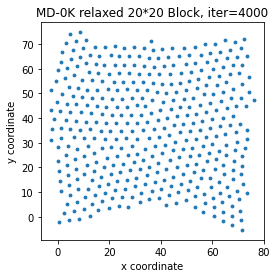

  8%|▊         | 7930/100001 [00:14<02:10, 707.86it/s]

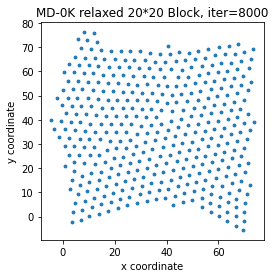

 16%|█▌        | 15945/100001 [00:26<02:41, 520.24it/s]

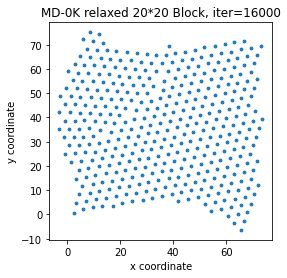

 30%|██▉       | 29945/100001 [00:47<01:34, 740.28it/s]

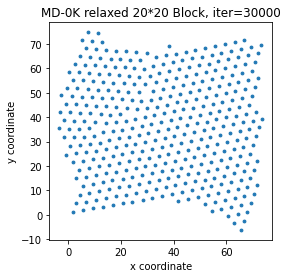

 50%|████▉     | 49987/100001 [01:17<01:45, 471.94it/s]

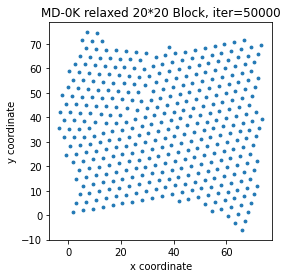

 75%|███████▍  | 74948/100001 [01:53<00:33, 753.26it/s]

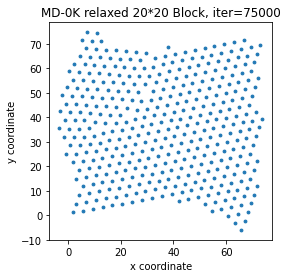

100%|█████████▉| 99943/100001 [02:31<00:00, 735.18it/s]

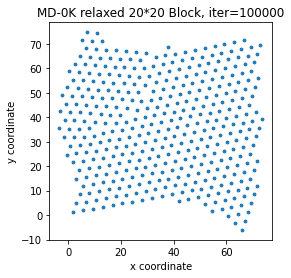

100%|██████████| 100001/100001 [02:31<00:00, 660.10it/s]


In [52]:
T_0K_init = 0
coords_0K = coords.copy()
iter_num_0K = 100000
dt=5e-15
coords_0K, E_p_0K, E_k_0K, hydrostress_0K, v_J_0K, T_0K, stopstep_0K = main_loop(coords_0K, iter_num=iter_num_0K, delta_t=dt, T_init=T_0K_init, tolerance_T=tolerance_T_0K)

#### *At this point you should get a relaxed structure like that found by molecular statics in part (A) above.*

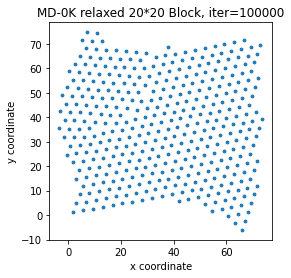

In [57]:
plot_block(coords_0K,stopstep_0K,0)

### !Save&load data of 0K

In [58]:
np.save('MD_coords_0K',coords_0K)
np.save('MD_E_p_0K',E_p_0K)
np.save('MD_E_k_0K',E_k_0K)
np.save('MD_sigma_h_0K',hydrostress_0K)
np.save('MD_velosity_0K',v_J_0K)
np.save('MD_Temperature_0K',T_0K)
np.save('MD_stopstep_0K',stopstep_0K)

In [59]:
coords_0K = np.load('MD_coords_0K.npy')
E_p_0K = np.load('MD_E_p_0K.npy')
E_k_0K = np.load('MD_E_k_0K.npy')
hydrostress_0K = np.load('MD_sigma_h_0K.npy')
v_J_0K = np.load('MD_velosity_0K.npy')
T_0K = np.load('MD_Temperature_0K.npy')
stopstep_0K = np.load('MD_stopstep_0K.npy')

### Check the results

#### *Check the value of the total pressure and if it is not zero, scale coordinates appropriately and repeat the MD simulation.*
#### *Display the structure of the block by depicting the atomic positions and determine the RDF.*

#### Total Potential & Kinetic Energy

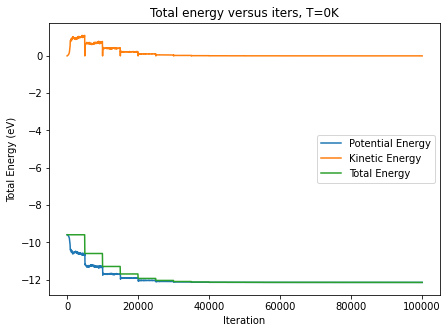

In [60]:
Plot_Ep_Ek(E_p_0K,E_k_0K,stopstep_0K,0)

#### RDF

length of r array
400
begining and end of r array
1.0 12.0


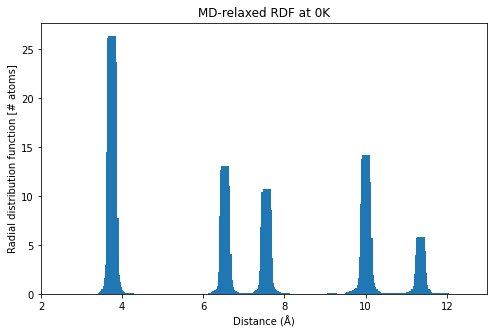

In [61]:
plot_rdf(coords_0K,title='MD-relaxed RDF at 0K')

#### Temperature

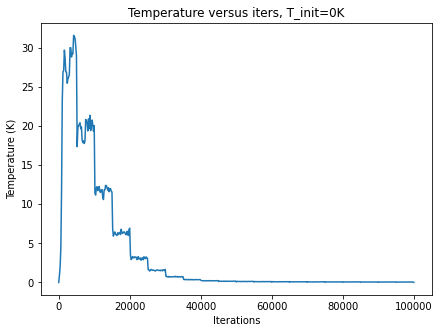

In [62]:
Plot_temperature(stopstep_0K,T_0K,0)

#### Total Hydrostatic Pressure versus Iterations

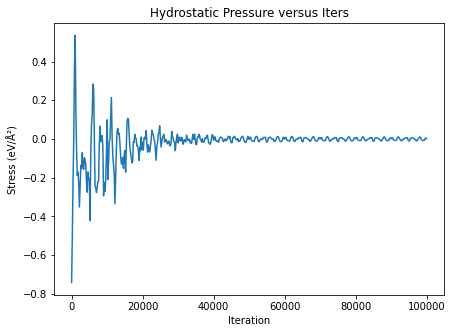

In [63]:
Plot_HS_tot(stopstep_0K,hydrostress_0K)

#### HS distribution on each atom

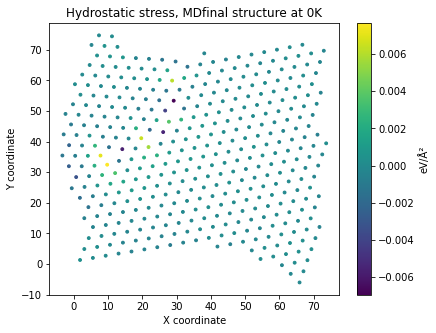

In [64]:
Plot_sigma_h(coords_0K,T_init=T_0K_init,Type='MD')

## 2. MD calculation at higher temperatures

### Increase the temperature gradually, using scaling of velocities, in steps of about 5K, up to about 85 K.
### In each case carry out the calculation until the thermodynamic equilibrium has been reached.

The new chosen temperatures are 5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,100 Kelvin, respectively

In [65]:
T_list_1 = [
    5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,100
]

#### Initialize datapack

In [66]:
datapack = {}

#### !Auto-running function for temperature_list

In [69]:
def running_MD_for_different_temperatures(T_list, coords_init, iter_num, datapack_init={}, dt=5e-15, tolerance_T_run=1.5):
    """Auto running program, should given the wanted temperatures as Temperature List

    Args:
        T_list (list): the series of temperatures we want to run for MD, Kelvin
        coords_init (numpy.ndarray): initial coordinate array, (400,2), angstrom
        iters (int, optional): number of iteration
        datapack_init(dict): an empty dictionary
        dt (float, optional): time step, second. Defaults to 5e-15.
        tolerance_T_run (float, optional): temperature threshold triggering rescaling. Defaults to 1.5. 

    Returns:
        dict: a zipped datapack recording all the simulation results, for each temperature, the key is str(temperature)+'K',
            e.g.: datapack['10K'] = coords_10K, E_p_10K, E_k_10K, hydrostress_10K, v_J_10K, T_10K, stopstep_10K
    """

    len_T = len(T_list)
    n=int(len(coords_init)**0.5)
    datapack = datapack_init
    for i in range(len_T):
        T_initial = T_list[i]
        iters = iter_num
        datapack[str(T_list[i])+'K'] = np.array(main_loop(coords_init,iter_num=iters,delta_t=dt,T_init=T_initial,tolerance_T=tolerance_T_run))
        np.save('MD_'+str(n)+'Block_'+str(T_initial)+'K_datapack',datapack[str(T_initial)+'K'])
    return datapack
    

#### Run MD at desire temperature of 5K~100K in Temperature list

  0%|          | 0/150001 [00:00<?, ?it/s]

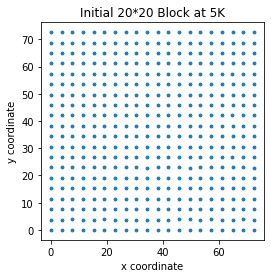

  0%|          | 165/150001 [00:00<04:54, 508.30it/s]

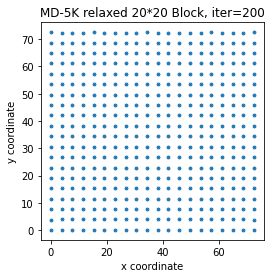

  0%|          | 498/150001 [00:00<03:46, 658.99it/s]

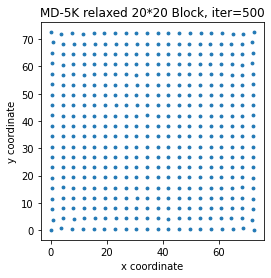

  1%|          | 957/150001 [00:01<03:38, 682.81it/s]

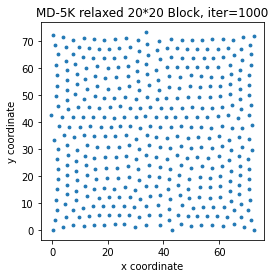

  1%|▏         | 1975/150001 [00:03<04:56, 498.61it/s]

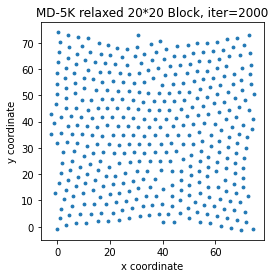

  3%|▎         | 3969/150001 [00:07<03:33, 685.26it/s]

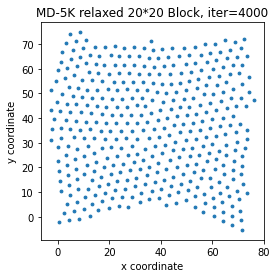

  5%|▌         | 7982/150001 [00:13<03:18, 716.21it/s]

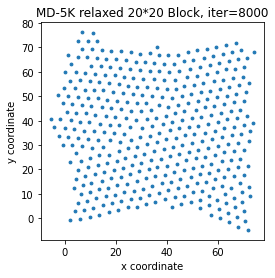

 11%|█         | 15937/150001 [00:25<03:01, 737.75it/s]

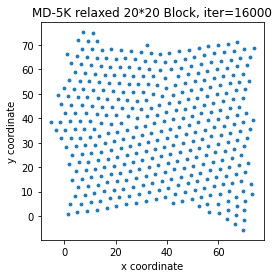

 20%|█▉        | 29953/150001 [00:47<02:43, 736.04it/s]

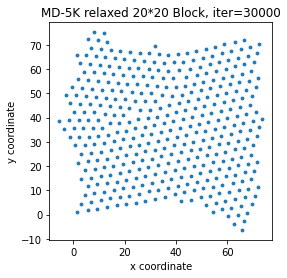

 33%|███▎      | 49965/150001 [01:17<02:14, 745.01it/s]

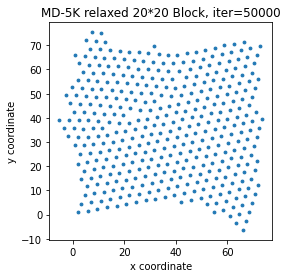

 50%|████▉     | 74969/150001 [01:55<01:45, 711.85it/s]

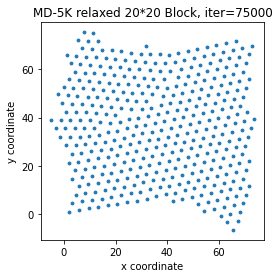

 67%|██████▋   | 99995/150001 [02:34<01:13, 676.49it/s]

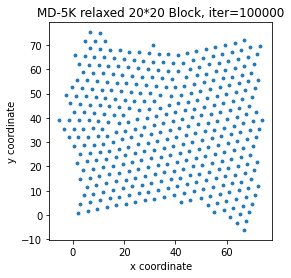

 93%|█████████▎| 139949/150001 [03:35<00:13, 727.79it/s]

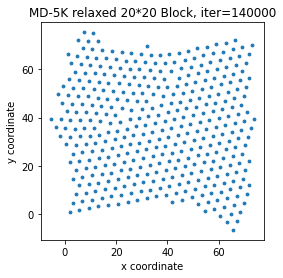

100%|██████████| 150001/150001 [03:50<00:00, 650.03it/s]
<ipython-input-69-7b2ea91210c6>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  datapack[str(T_list[i])+'K'] = np.array(main_loop(coords_init,iter_num=iters,delta_t=dt,T_init=T_initial,tolerance_T=tolerance_T_run))
 30%|██▉       | 45000/150001 [00:57<02:13, 788.64it/s]


In [71]:
datapack = running_MD_for_different_temperatures(T_list=T_list_1, coords_init=coords_MD, iter_num=150000, dt=5e-15)

#### Define save_data functions for packs of MD results

In [72]:
def save_datapack(T_init):
    """Save simulation result data as .npy files.

    Args:
        T_init (int): The certain temperature we want to save its results.
    """
    np.save('MD_'+str(T_init)+'K_datapack',datapack[str(T_init)+'K'])

#### !Save data (as datapacks)
*If you are the first time constructing data after series of MD relaxation, please remember* ***DOWNLOAD*** the **.npy** *files.*

*If you are **re-loading** previously saved after-relaxed data, please only run this part and **afterwards**.*

***DO NOT RUN AGAIN*** *the MD procedures written before.*

In [73]:
# Save datapacks of each temperature, naming as 'MD_?K_datapack.npy'
# It may take a several minutes to save
for i in range(len(T_list_1)):
    save_datapack(T_list_1[i])

#### Load datapacks

In [74]:
# load all the datapacks
T_list_1 = [
    5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,100
]
datapack = {}
for i in range(len(T_list_1)):
    datapack[str(T_list_1[i])+'K'] =np.load('MD_'+str(T_list_1[i])+'K_datapack.npy',allow_pickle=True)

### Analyze the structure of the block by the direct display of atomic positions and by determining the RDF

#### Plot MD-10K results

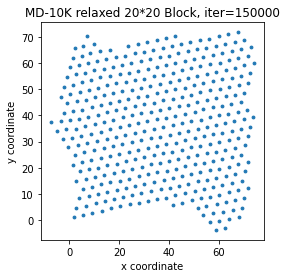

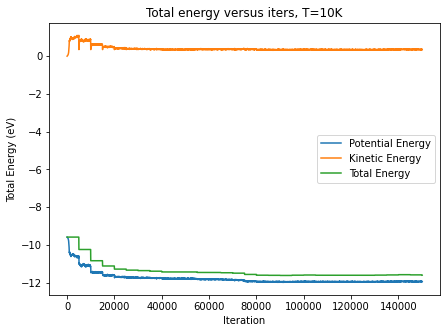

length of r array
400
begining and end of r array
1.0 12.0


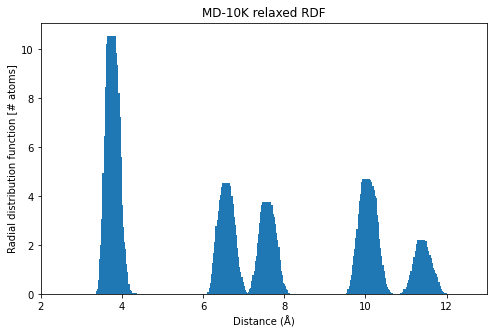

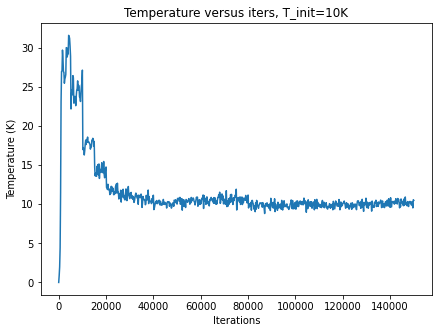

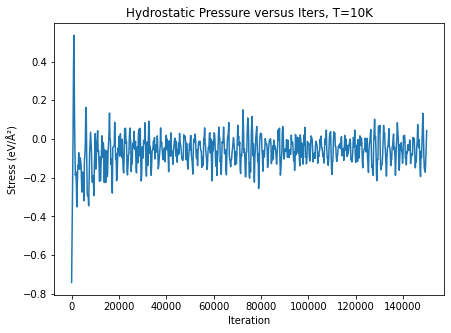

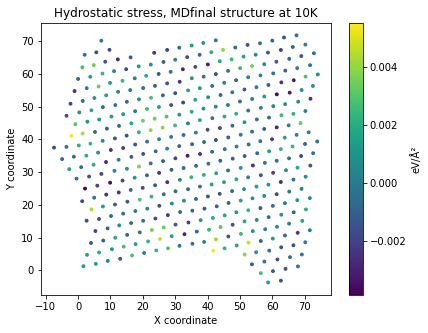

In [75]:
coords_10K, E_p_10K, E_k_10K, hydrostress_10K, v_J_10K, T_10K, stopstep_10K = datapack['10K']
Plot_results(coords_10K, E_p_10K, E_k_10K, hydrostress_10K, T_10K, 10, stopstep_10K)

#### Plot MD-15K results

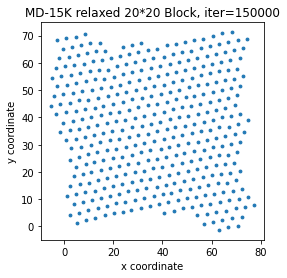

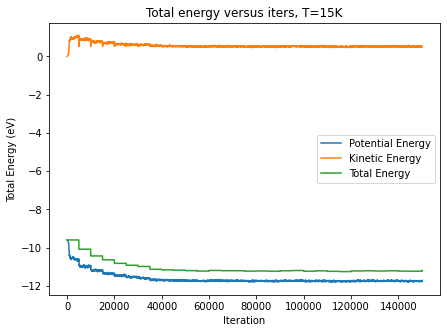

length of r array
400
begining and end of r array
1.0 12.0


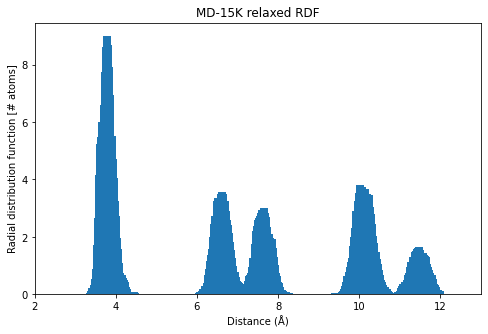

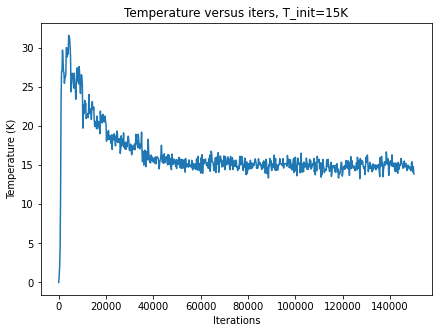

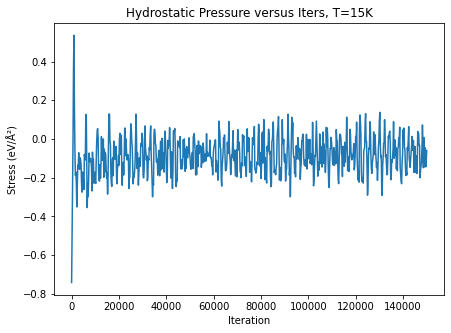

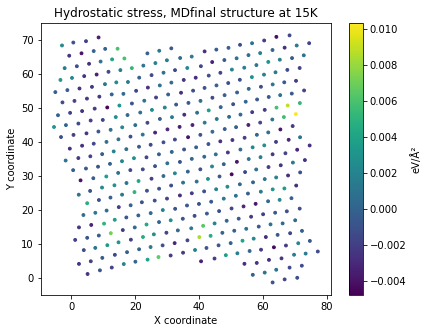

In [76]:
coords_15K, E_p_15K, E_k_15K, hydrostress_15K, v_J_15K, T_15K, stopstep_15K = datapack['15K']
Plot_results(coords_15K, E_p_15K, E_k_15K, hydrostress_15K, T_15K, 15, stopstep_15K)

#### Plot MD-20K results

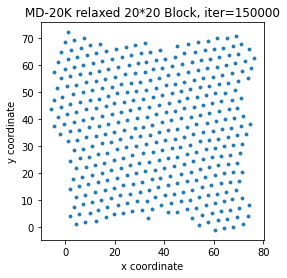

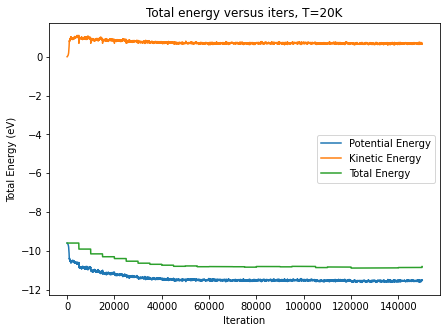

length of r array
400
begining and end of r array
1.0 12.0


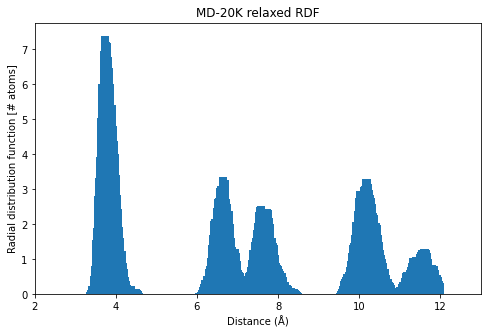

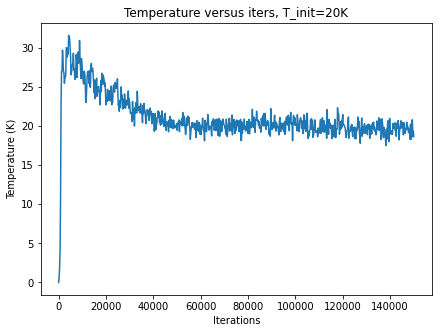

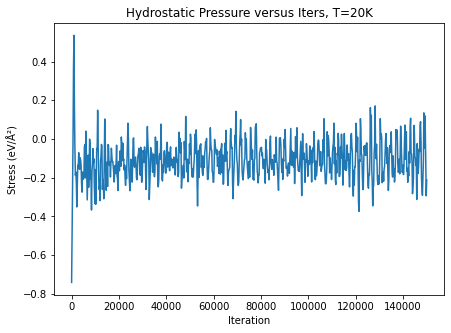

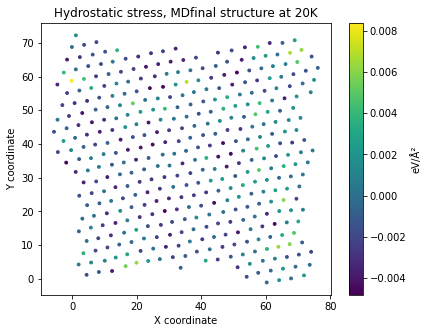

In [77]:
coords_20K, E_p_20K, E_k_20K, hydrostress_20K, v_J_20K, T_20K, stopstep_20K = datapack['20K']
Plot_results(coords_20K, E_p_20K, E_k_20K, hydrostress_20K, T_20K, 20, stopstep_20K)

#### Plot MD-25K results

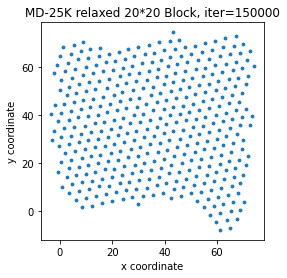

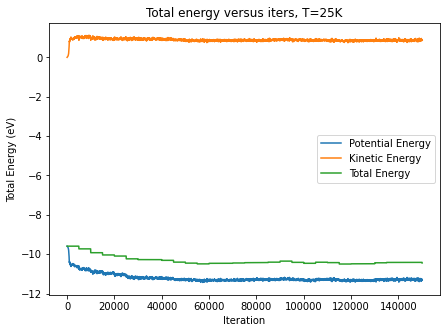

length of r array
400
begining and end of r array
1.0 12.0


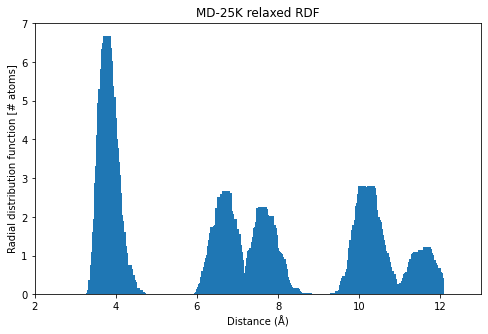

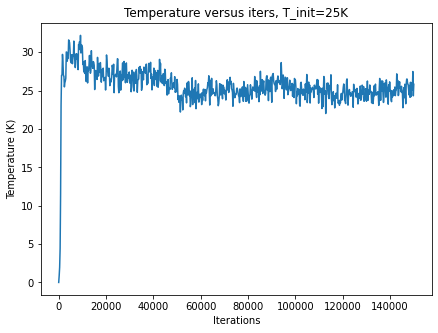

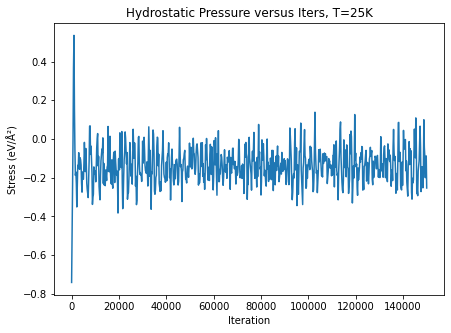

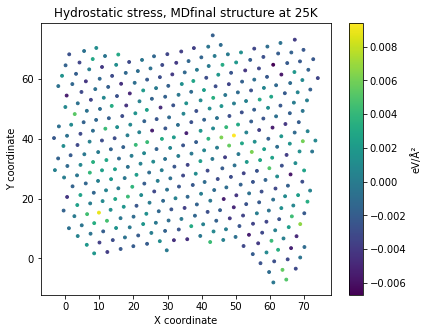

In [78]:
coords_25K, E_p_25K, E_k_25K, hydrostress_25K, v_J_25K, T_25K, stopstep_25K = datapack['25K']
Plot_results(coords_25K, E_p_25K, E_k_25K, hydrostress_25K, T_25K, 25, stopstep_25K)

#### Plot MD-30K results

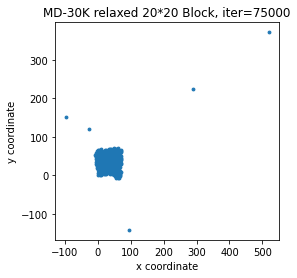

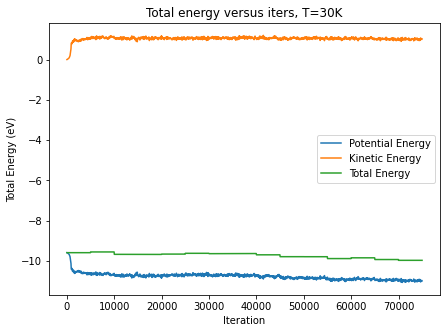

length of r array
400
begining and end of r array
1.0 12.0


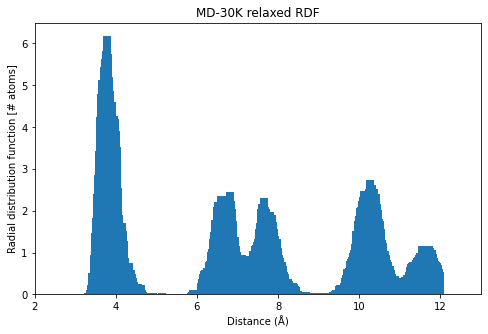

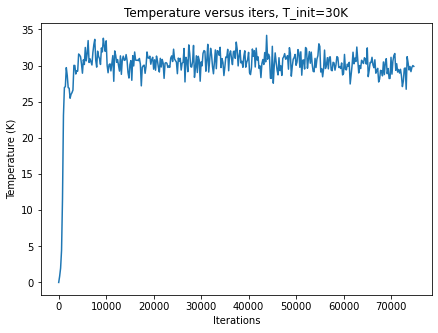

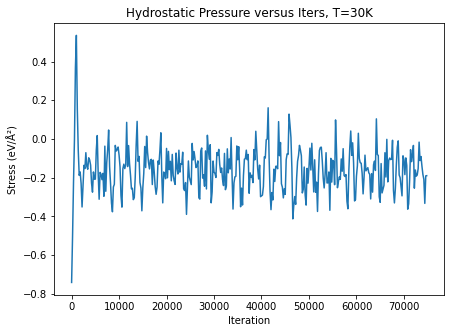

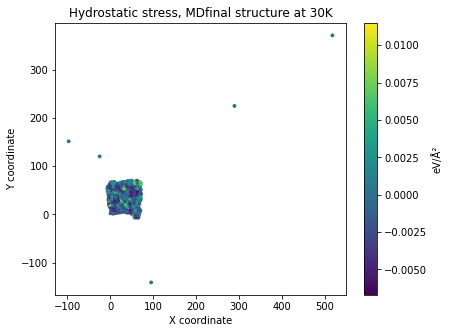

In [79]:
coords_30K, E_p_30K, E_k_30K, hydrostress_30K, v_J_30K, T_30K, stopstep_30K = datapack['30K']
Plot_results(coords_30K, E_p_30K, E_k_30K, hydrostress_30K, T_30K, 30, stopstep_30K)

#### Plot MD-35K results

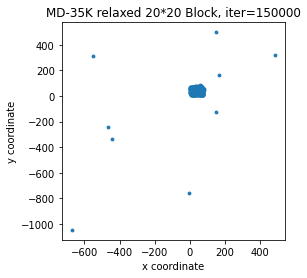

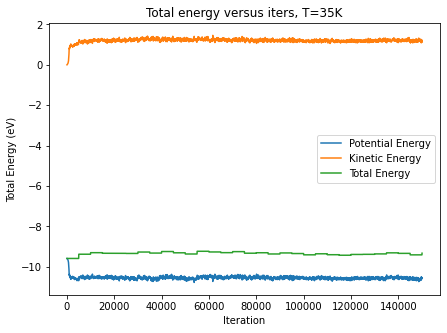

length of r array
400
begining and end of r array
1.0 12.0


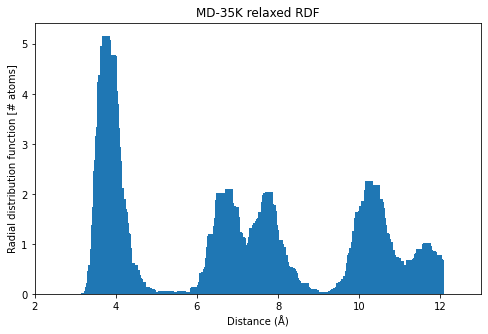

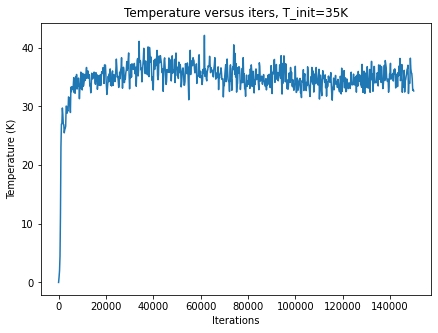

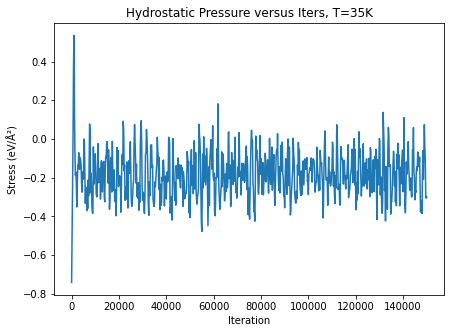

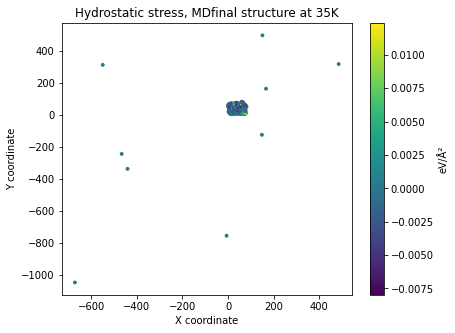

In [80]:
coords_35K, E_p_35K, E_k_35K, hydrostress_35K, v_J_35K, T_35K, stopstep_35K = datapack['35K']
Plot_results(coords_35K, E_p_35K, E_k_35K, hydrostress_35K, T_35K, 35, stopstep_35K)

#### Plot MD-40K results

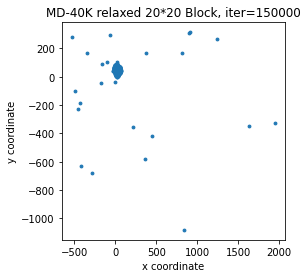

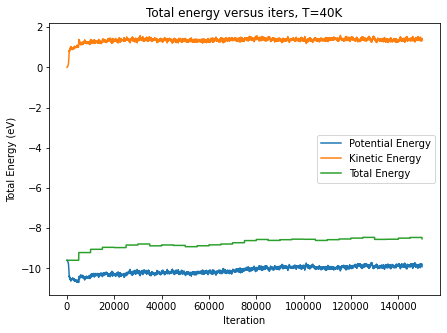

length of r array
400
begining and end of r array
1.0 12.0


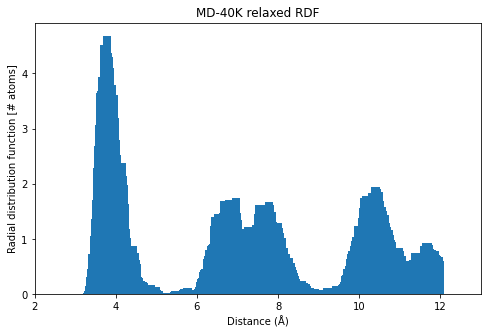

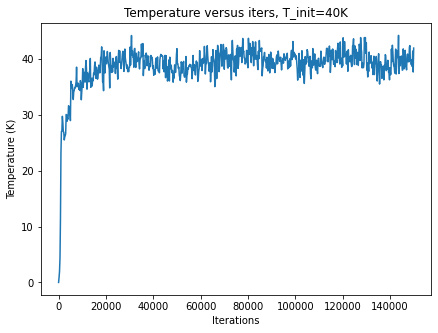

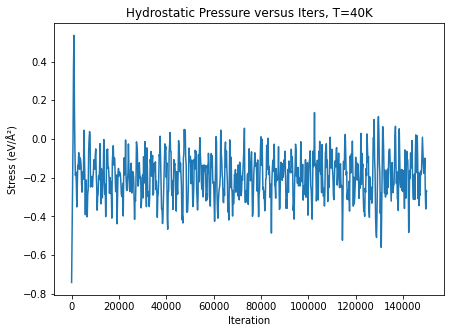

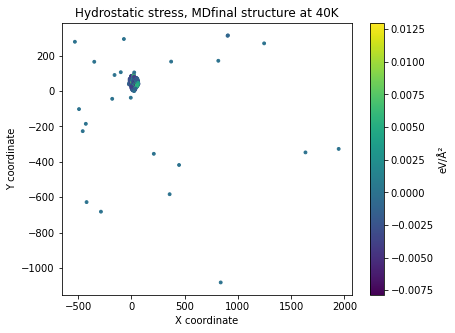

In [81]:
coords_40K, E_p_40K, E_k_40K, hydrostress_40K, v_J_40K, T_40K, stopstep_40K = datapack['40K']
Plot_results(coords_40K, E_p_40K, E_k_40K, hydrostress_40K, T_40K, 40, stopstep_40K)

#### Plot MD-45K results

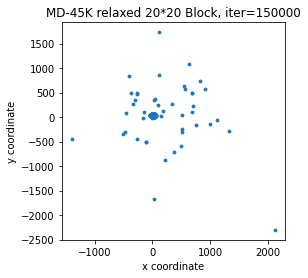

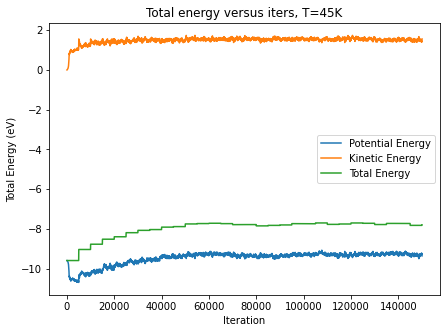

length of r array
400
begining and end of r array
1.0 12.0


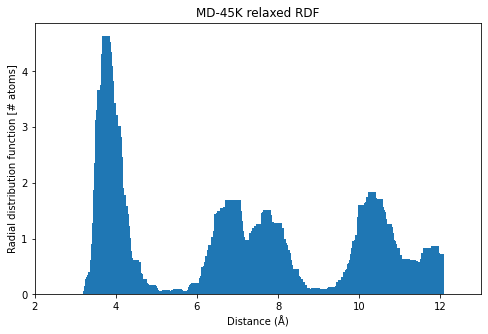

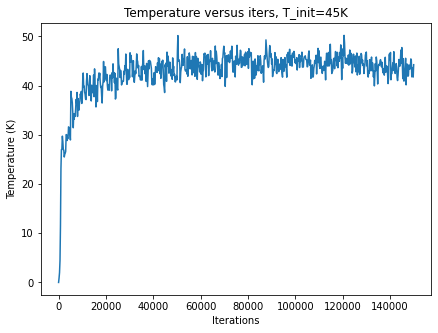

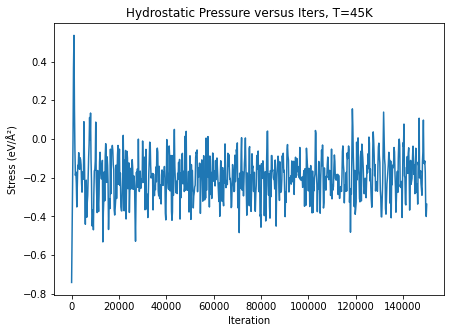

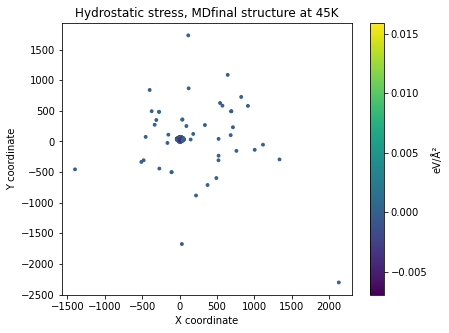

In [82]:
coords_45K, E_p_45K, E_k_45K, hydrostress_45K, v_J_45K, T_45K, stopstep_45K = datapack['45K']
Plot_results(coords_45K, E_p_45K, E_k_45K, hydrostress_45K, T_45K, 45, stopstep_45K)

#### Plot MD-50K results

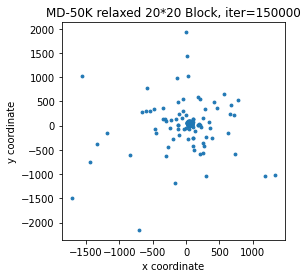

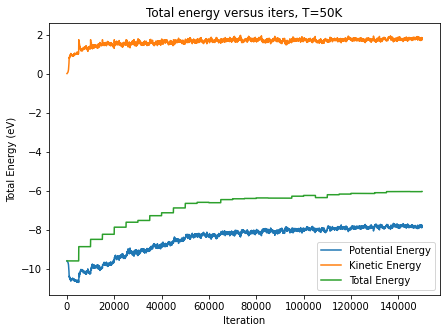

length of r array
400
begining and end of r array
1.0 12.0


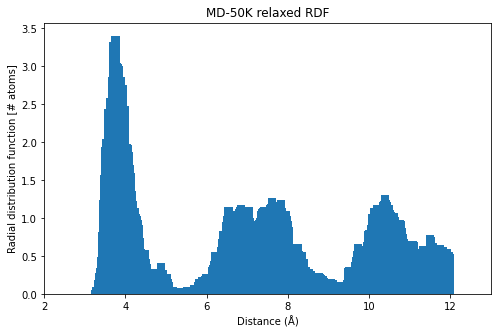

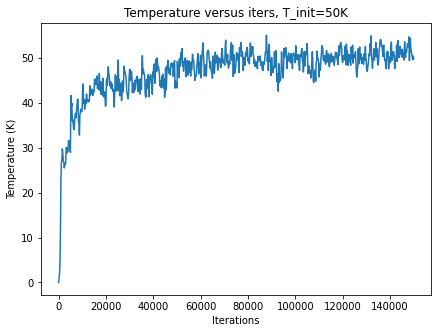

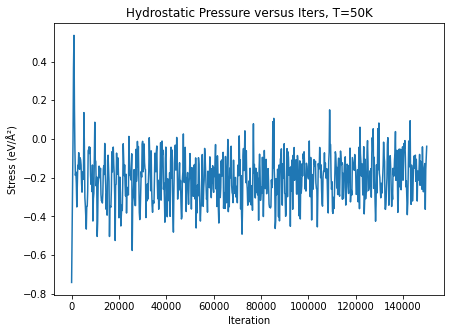

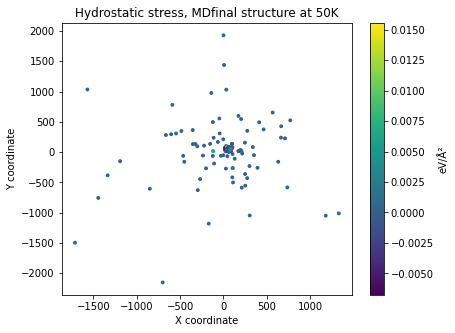

In [83]:
coords_50K, E_p_50K, E_k_50K, hydrostress_50K, v_J_50K, T_50K, stopstep_50K = datapack['50K']
Plot_results(coords_50K, E_p_50K, E_k_50K, hydrostress_50K, T_50K, 50, stopstep_50K)

#### Plot MD-55K results

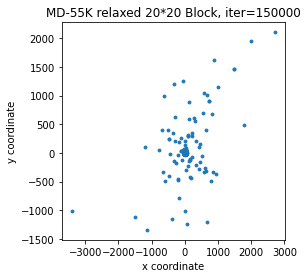

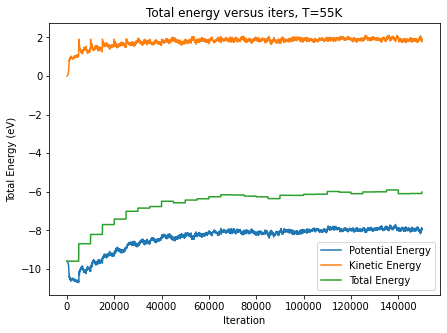

length of r array
400
begining and end of r array
1.0 12.0


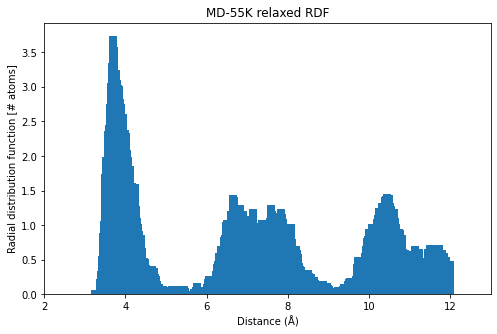

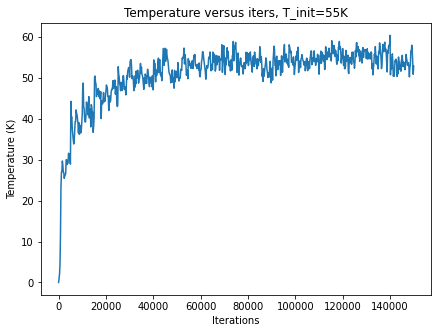

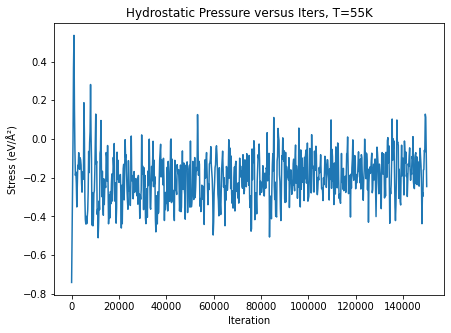

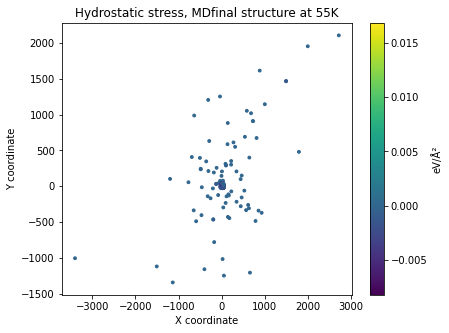

In [84]:
coords_55K, E_p_55K, E_k_55K, hydrostress_55K, v_J_55K, T_55K, stopstep_55K = datapack['55K']
Plot_results(coords_55K, E_p_55K, E_k_55K, hydrostress_55K, T_55K, 55, stopstep_55K)

#### Plot MD-60K results

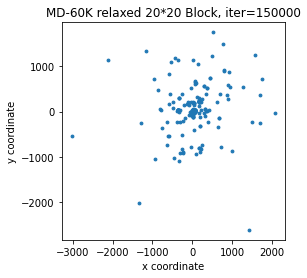

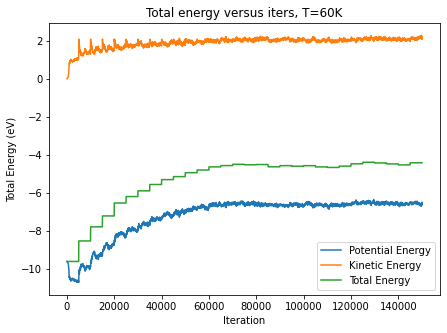

length of r array
400
begining and end of r array
1.0 12.0


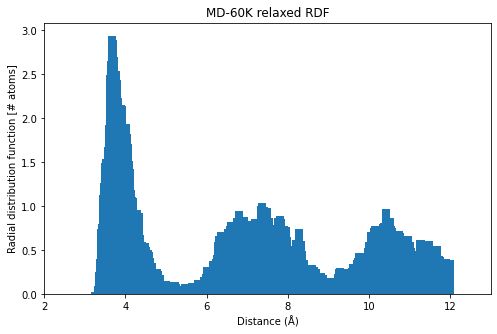

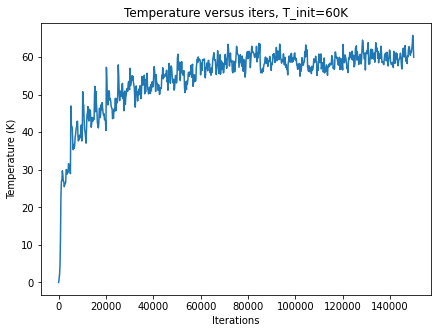

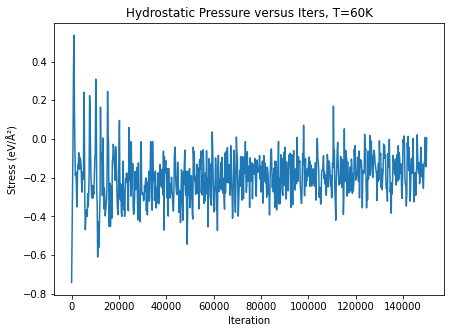

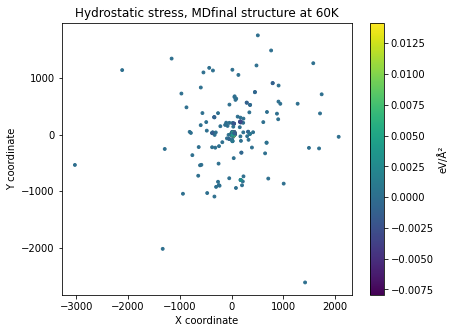

In [85]:
coords_60K, E_p_60K, E_k_60K, hydrostress_60K, v_J_60K, T_60K, stopstep_60K = datapack['60K']
Plot_results(coords_60K, E_p_60K, E_k_60K, hydrostress_60K, T_60K, 60, stopstep_60K)

In [86]:
# coords_60K, E_p_60K, E_k_60K, hydrostress_60K, v_J_60K, T_60K, stopstep_60K = datapack['60K']
# Plot_results(coords_60K, E_p_60K, E_k_60K, hydrostress_60K, T_60K, 60, stopstep_60K)

#### Plot MD-65K results

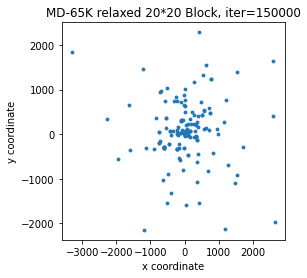

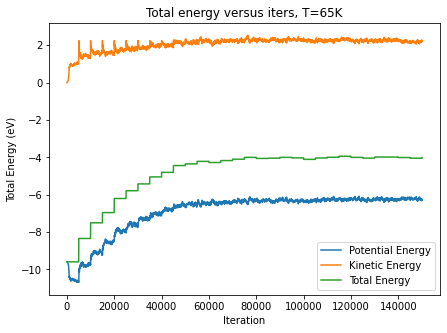

length of r array
400
begining and end of r array
1.0 12.0


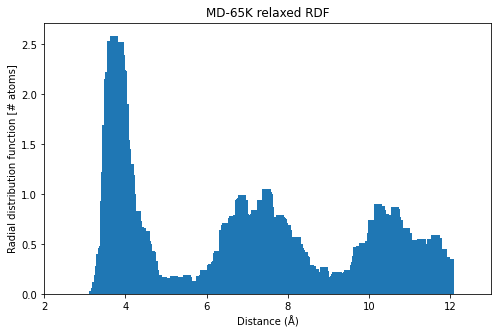

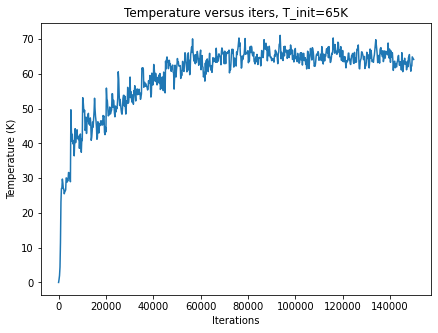

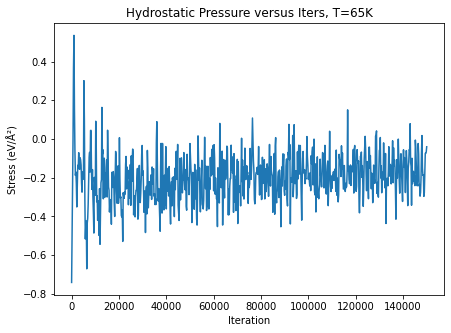

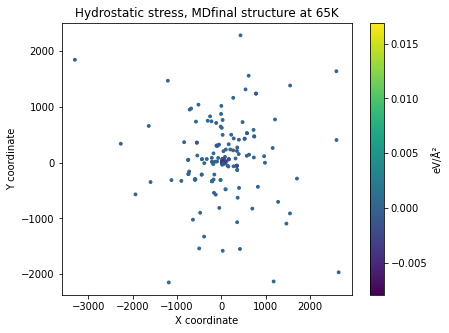

In [87]:
coords_65K, E_p_65K, E_k_65K, hydrostress_65K, v_J_65K, T_65K, stopstep_65K = datapack['65K']
Plot_results(coords_65K, E_p_65K, E_k_65K, hydrostress_65K, T_65K, 65, stopstep_65K)

#### Plot MD-70K results

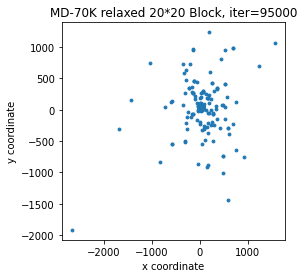

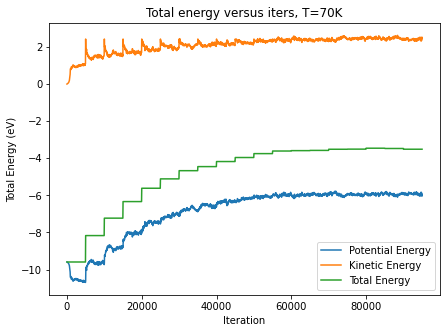

length of r array
400
begining and end of r array
1.0 12.0


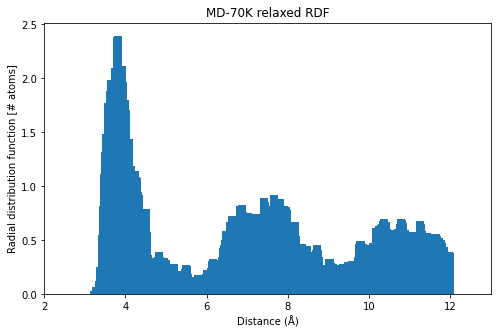

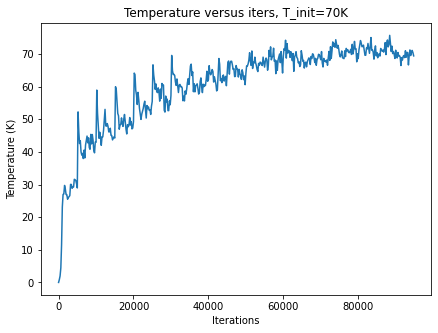

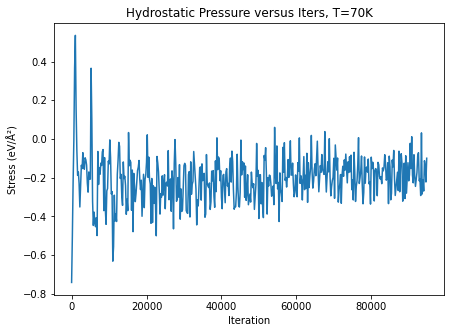

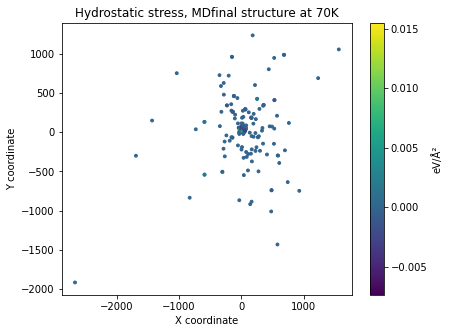

In [88]:
coords_70K, E_p_70K, E_k_70K, hydrostress_70K, v_J_70K, T_70K, stopstep_70K = datapack['70K']
Plot_results(coords_70K, E_p_70K, E_k_70K, hydrostress_70K, T_70K, 70, stopstep_70K)

#### Plot MD-75K results

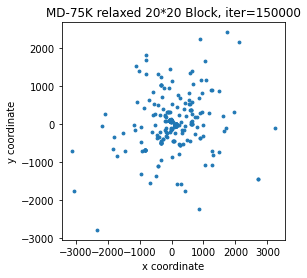

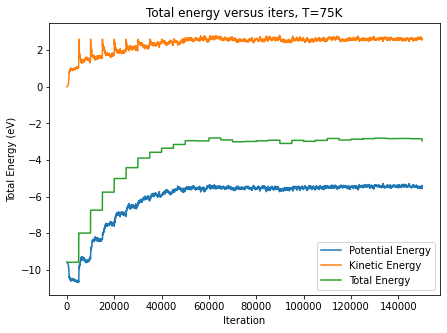

length of r array
400
begining and end of r array
1.0 12.0


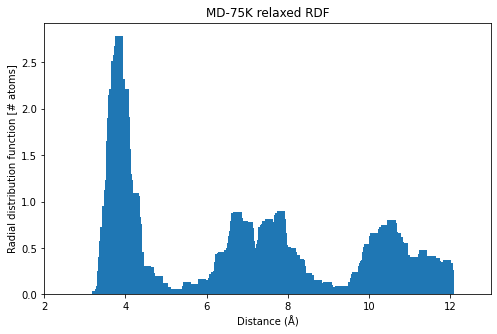

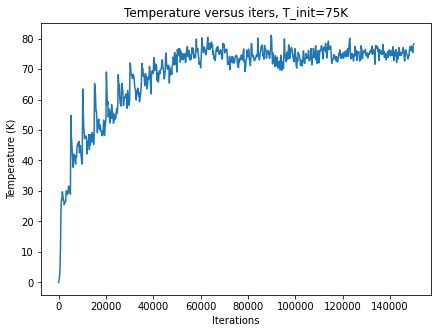

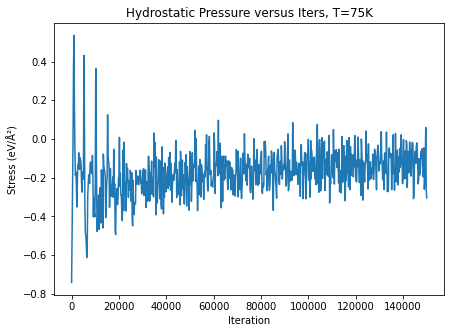

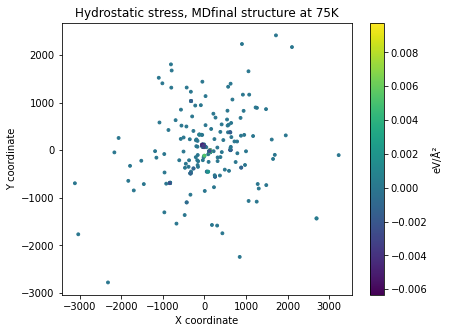

In [89]:
coords_75K, E_p_75K, E_k_75K, hydrostress_75K, v_J_75K, T_75K, stopstep_75K = datapack['75K']
Plot_results(coords_75K, E_p_75K, E_k_75K, hydrostress_75K, T_75K, 75, stopstep_75K)

#### Plot MD-80K results

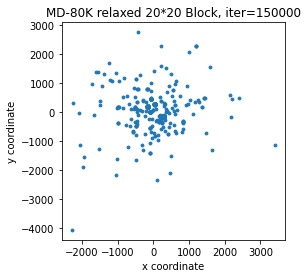

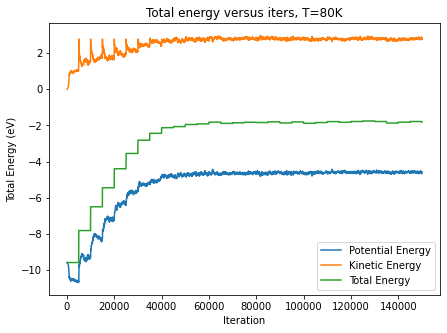

length of r array
400
begining and end of r array
1.0 12.0


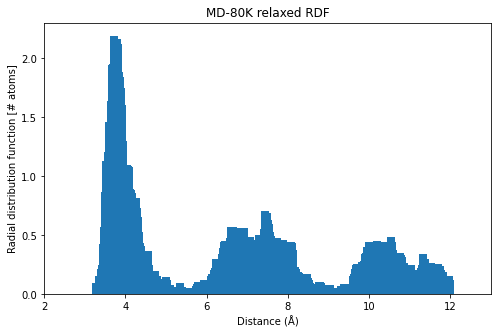

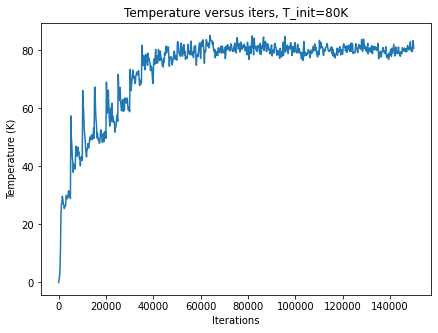

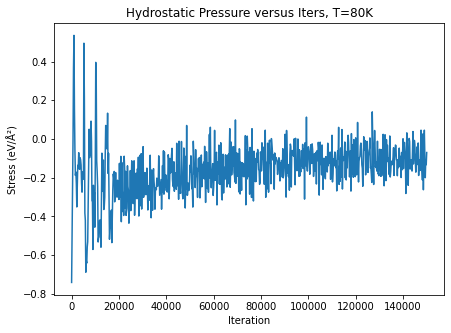

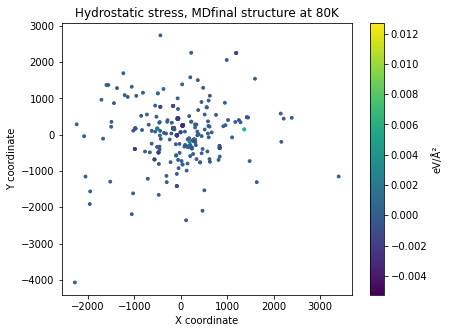

In [90]:
coords_80K, E_p_80K, E_k_80K, hydrostress_80K, v_J_80K, T_80K, stopstep_80K = datapack['80K']
Plot_results(coords_80K, E_p_80K, E_k_80K, hydrostress_80K, T_80K, 80, stopstep_80K)

#### Plot MD-85K results

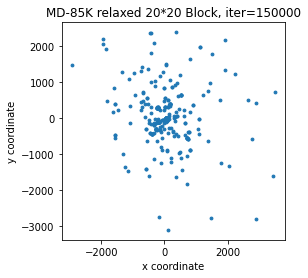

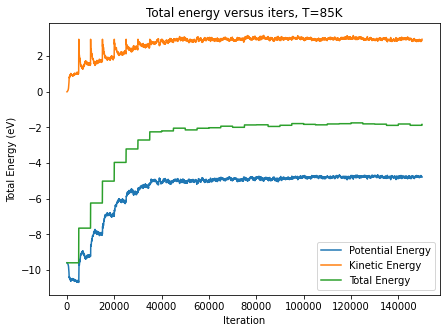

length of r array
400
begining and end of r array
1.0 12.0


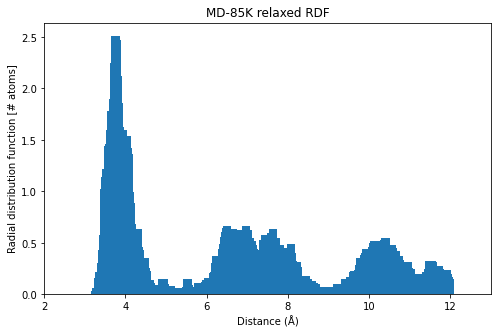

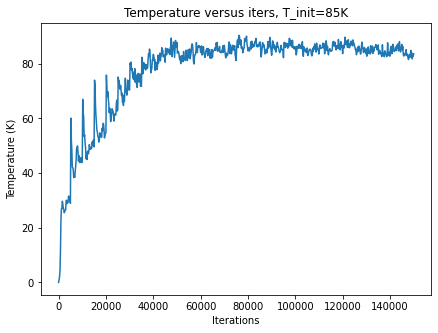

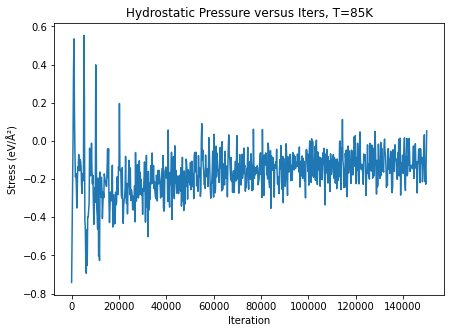

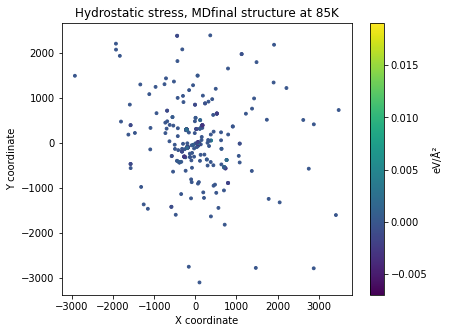

In [91]:
coords_85K, E_p_85K, E_k_85K, hydrostress_85K, v_J_85K, T_85K, stopstep_85K = datapack['85K']
Plot_results(coords_85K, E_p_85K, E_k_85K, hydrostress_85K, T_85K, 85, stopstep_85K)

#### Plot MD-90K results

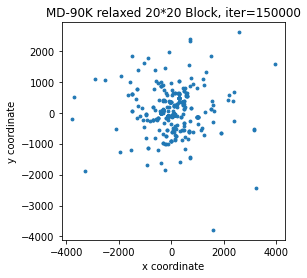

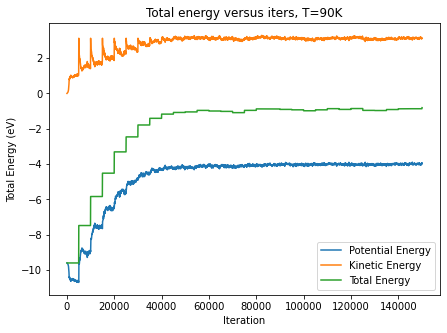

length of r array
400
begining and end of r array
1.0 12.0


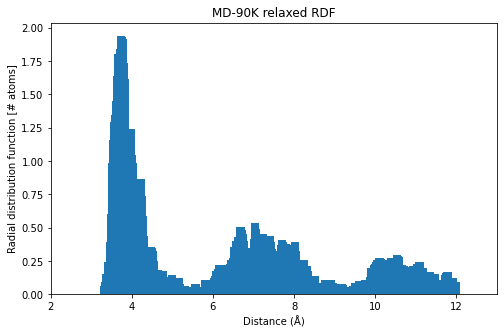

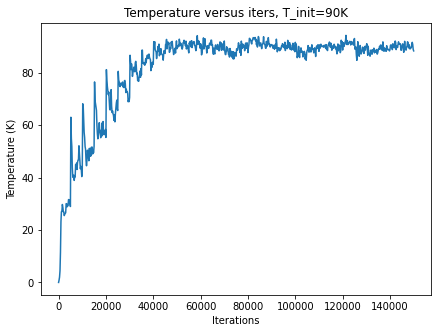

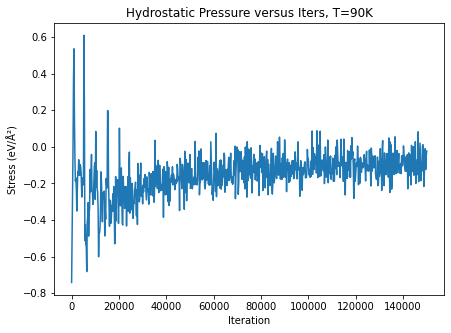

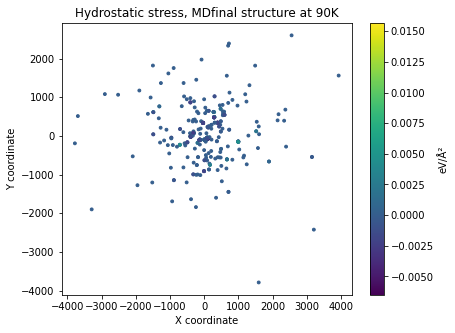

In [92]:
coords_90K, E_p_90K, E_k_90K, hydrostress_90K, v_J_90K, T_90K, stopstep_90K = datapack['90K']
Plot_results(coords_90K, E_p_90K, E_k_90K, hydrostress_90K, T_90K, 90, stopstep_90K)

#### Plot MD-100K results

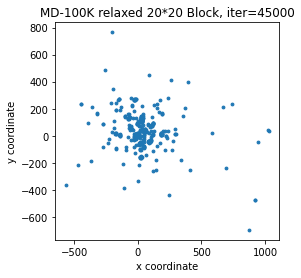

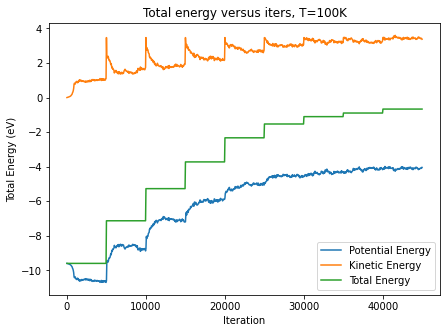

length of r array
400
begining and end of r array
1.0 12.0


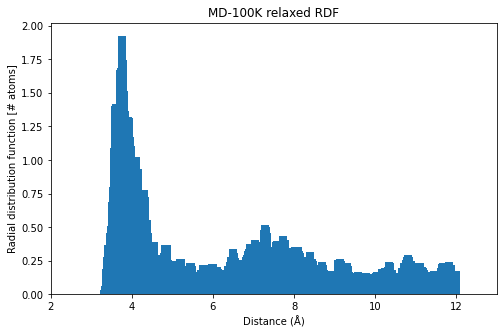

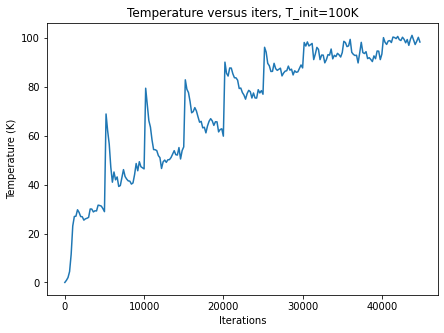

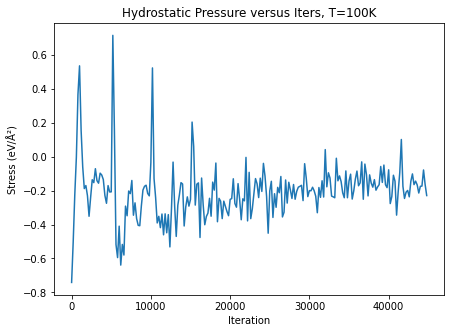

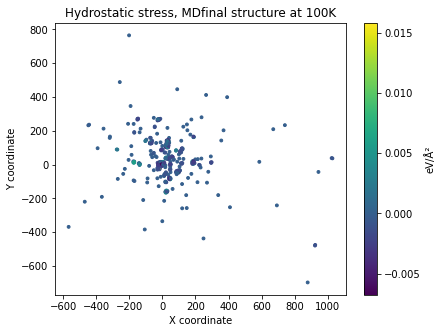

In [93]:
coords_100K, E_p_100K, E_k_100K, hydrostress_100K, v_J_100K, T_100K, stopstep_100K = datapack['100K']
Plot_results(coords_100K, E_p_100K, E_k_100K, hydrostress_100K, T_100K, 100, stopstep_100K)

#### *State whether the material is crystalline, liquid or possibly gas at every temperature and briefly explain your answer.* 

At 10K, the the material is crystalline

At 20K, the the material is crystalline

At 40K, the the material is crystalline

At 80K, the the material consists of crystalline and liquid

#### Actually we can run only once for plotting by following the T_list

In [94]:
# load all the datapacks
T_list_1 = [
    5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,100
]
datapack_1 = {}
for i in range(len(T_list_1)):
    datapack_1[str(T_list_1[i])+'K'] =np.load('MD_'+str(T_list_1[i])+'K_datapack.npy',allow_pickle=True)

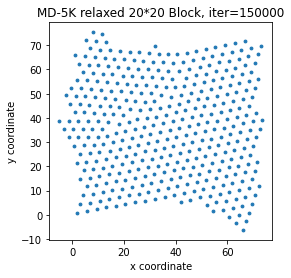

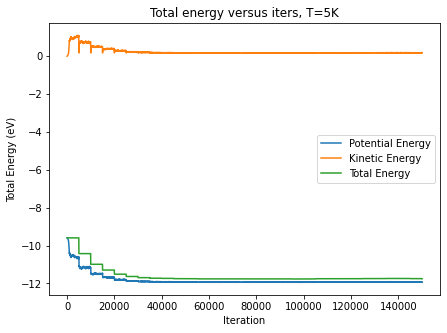

length of r array
400
begining and end of r array
1.0 12.0


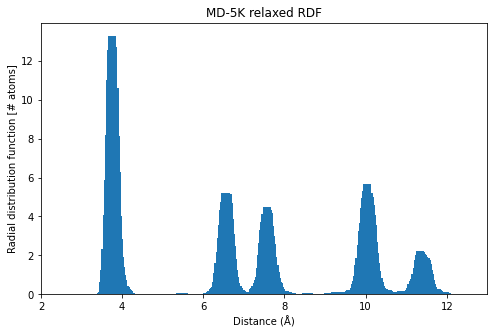

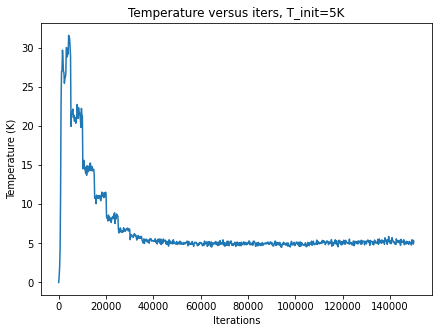

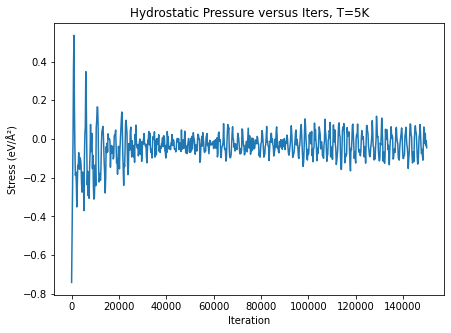

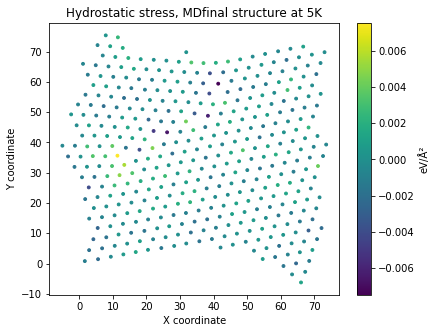

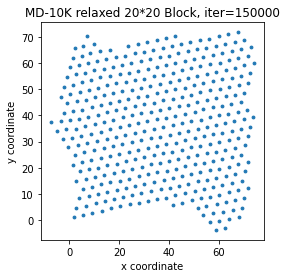

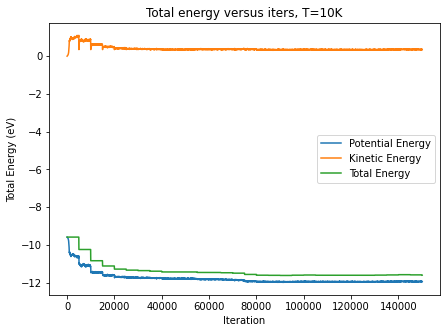

length of r array
400
begining and end of r array
1.0 12.0


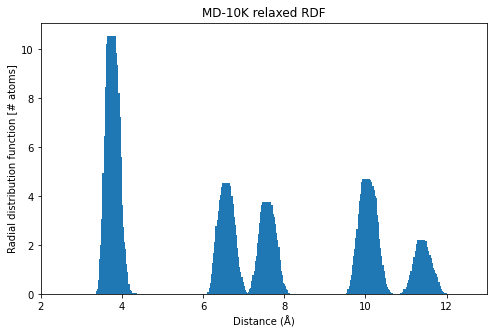

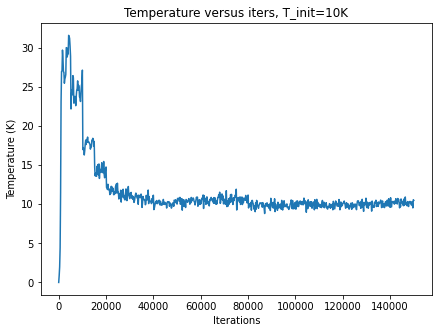

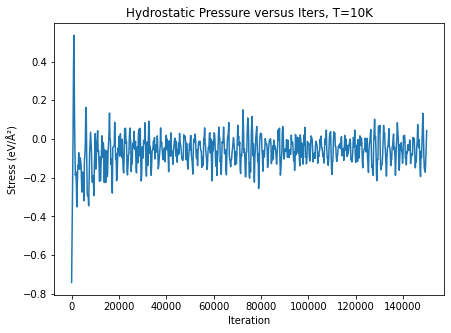

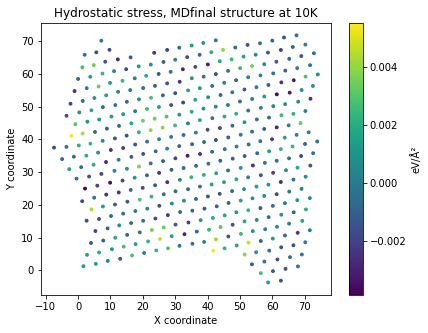

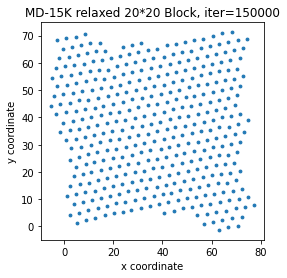

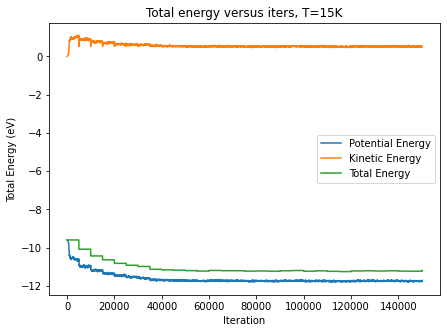

length of r array
400
begining and end of r array
1.0 12.0


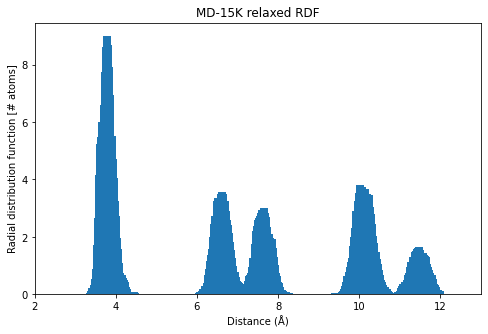

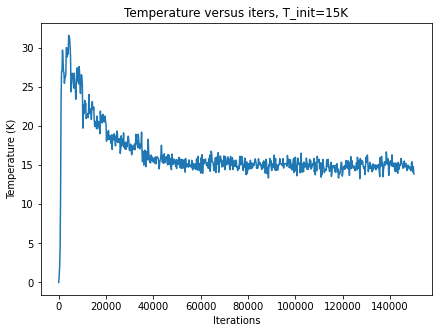

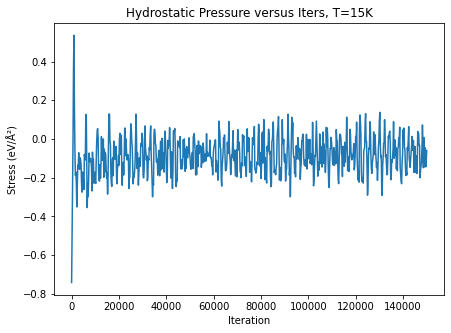

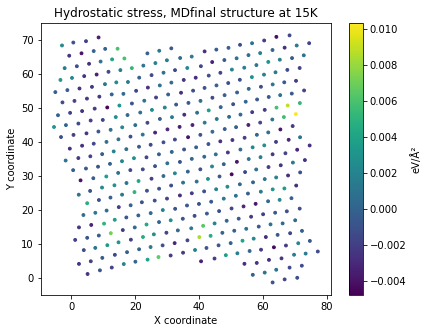

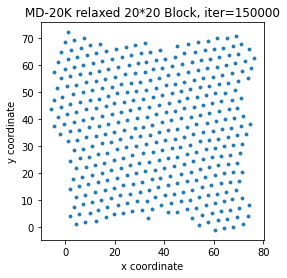

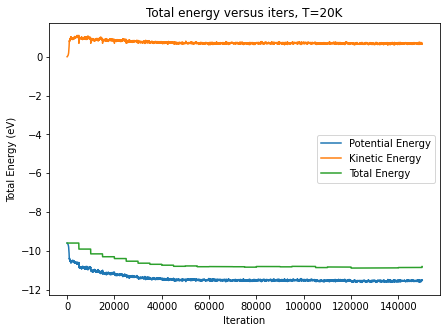

length of r array
400
begining and end of r array
1.0 12.0


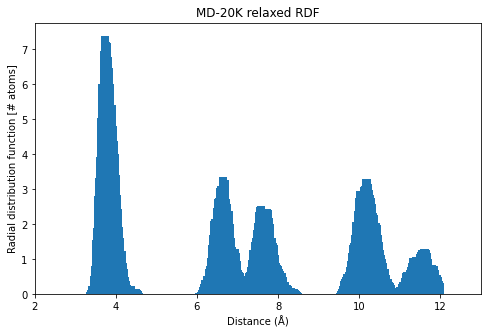

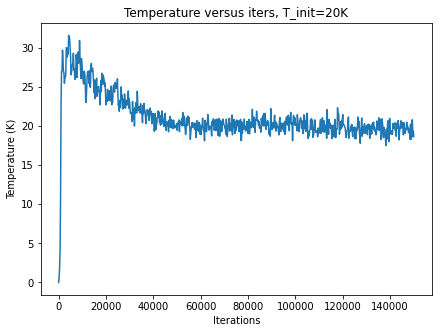

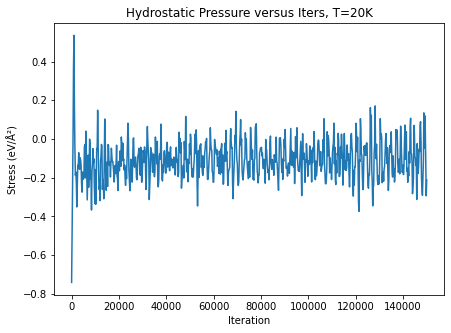

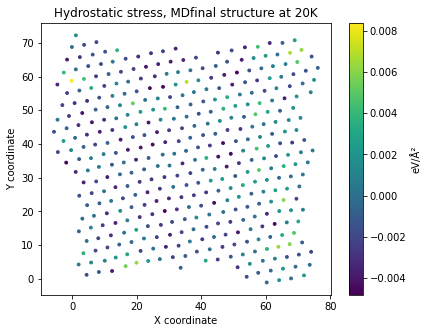

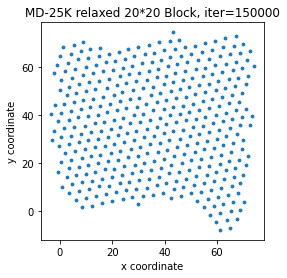

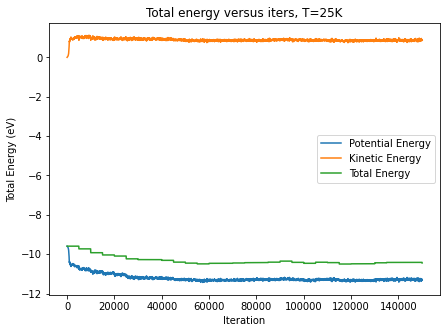

length of r array
400
begining and end of r array
1.0 12.0


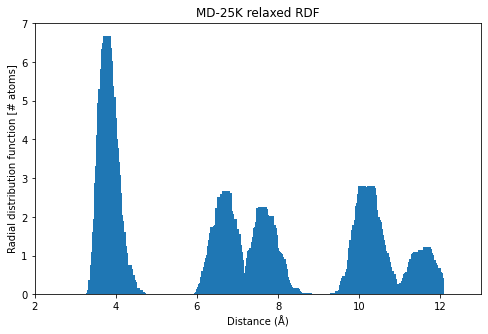

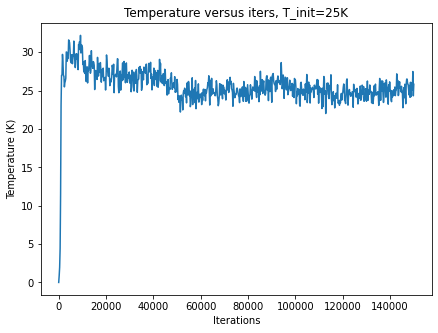

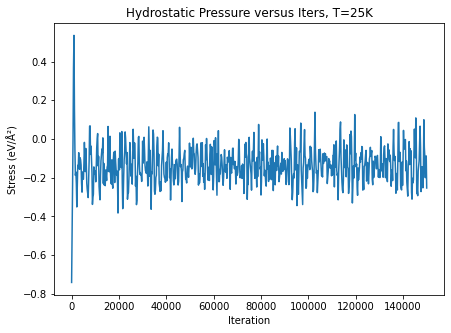

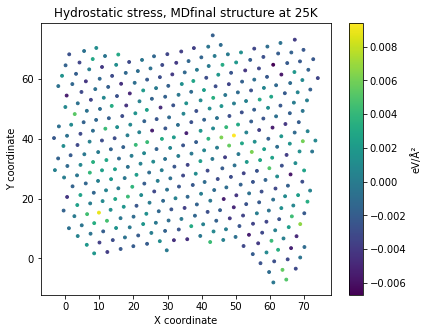

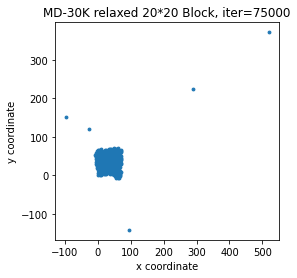

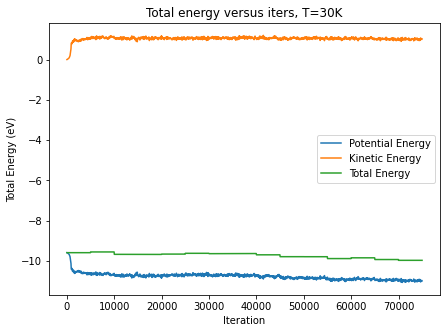

length of r array
400
begining and end of r array
1.0 12.0


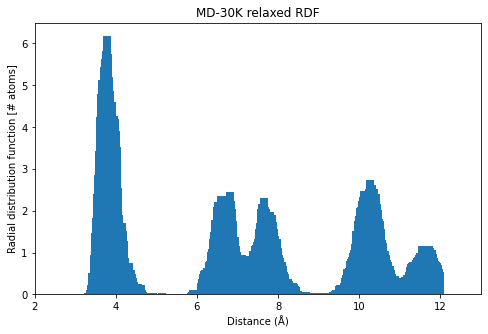

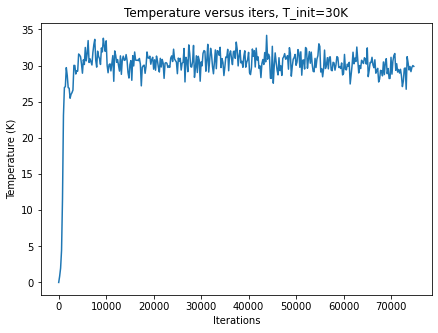

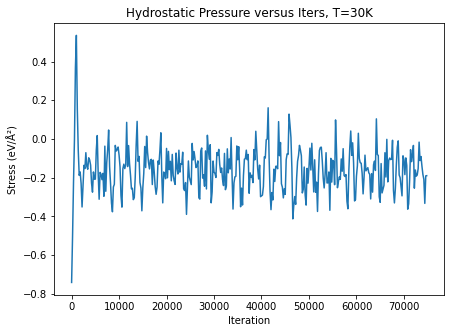

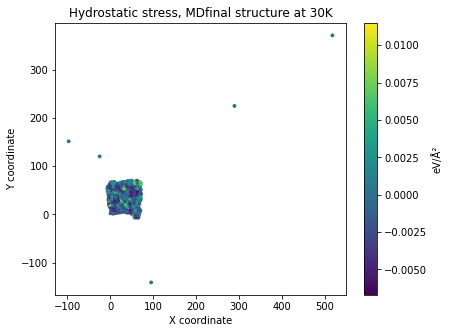

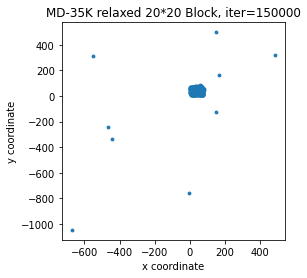

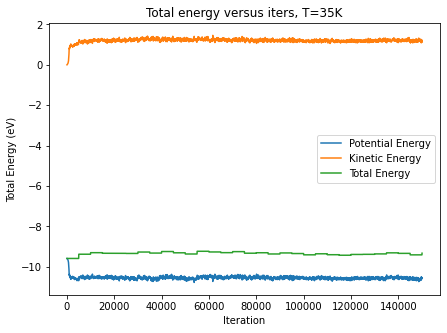

length of r array
400
begining and end of r array
1.0 12.0


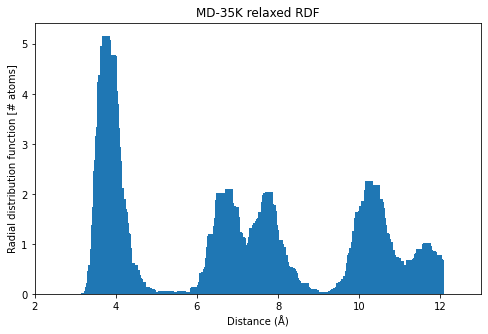

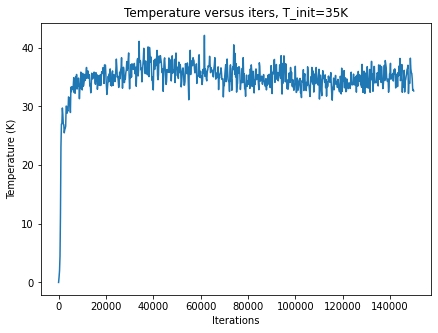

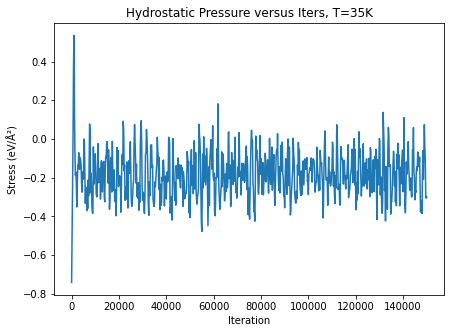

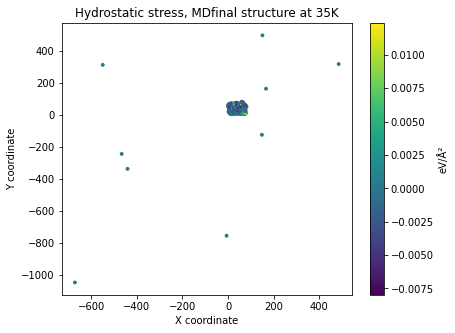

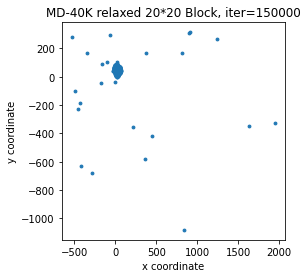

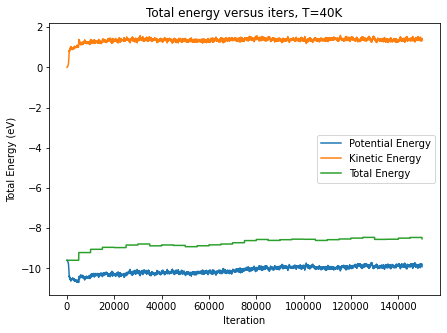

length of r array
400
begining and end of r array
1.0 12.0


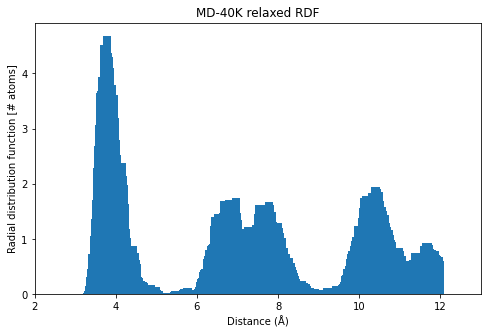

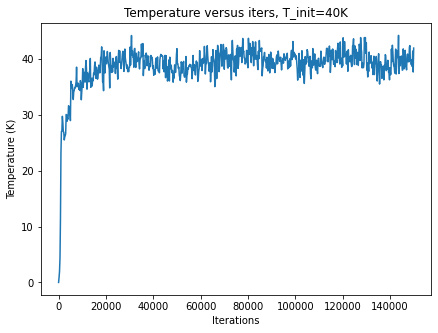

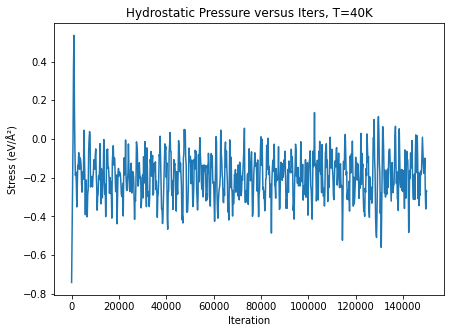

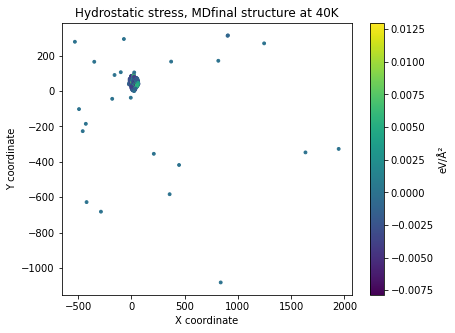

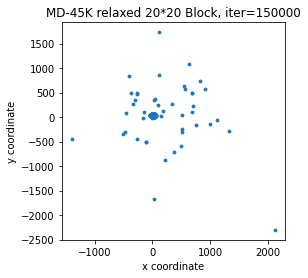

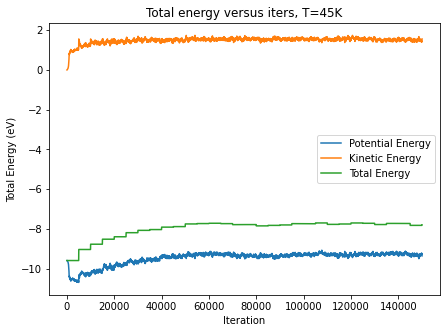

length of r array
400
begining and end of r array
1.0 12.0


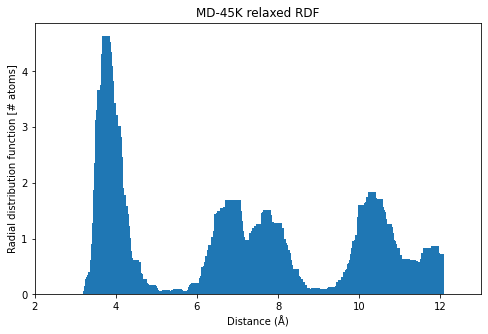

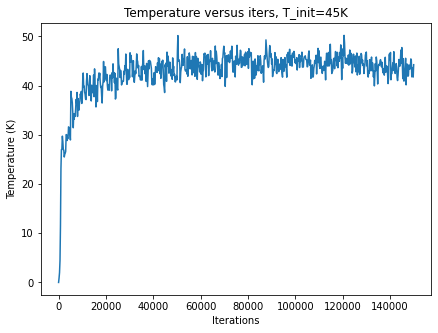

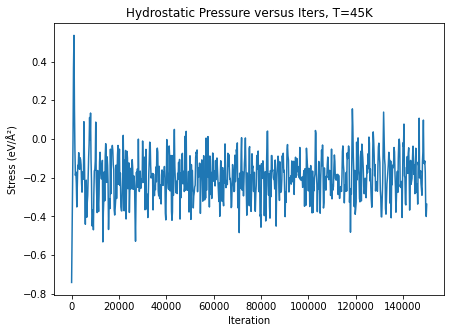

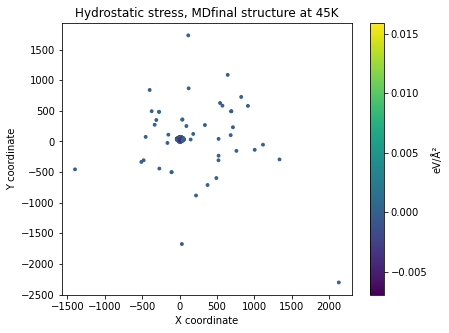

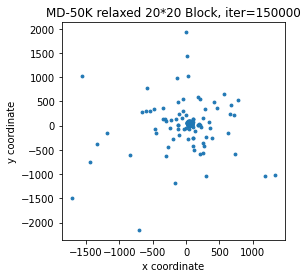

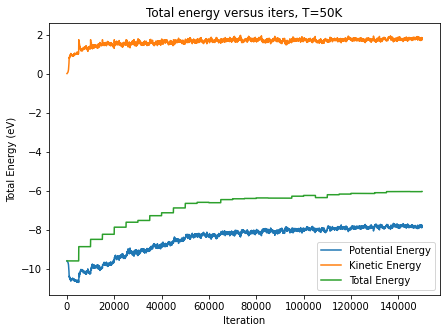

length of r array
400
begining and end of r array
1.0 12.0


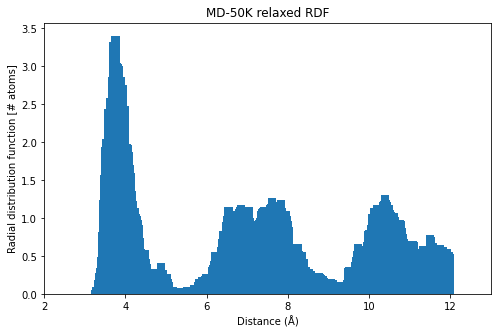

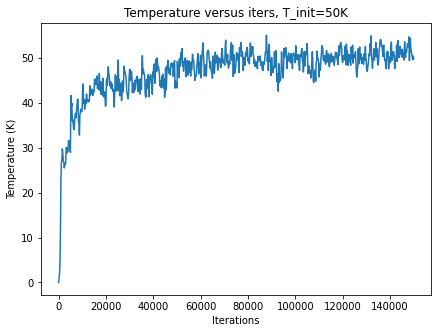

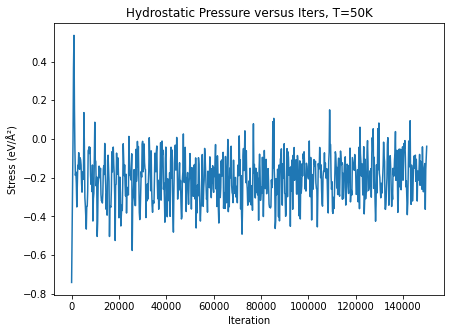

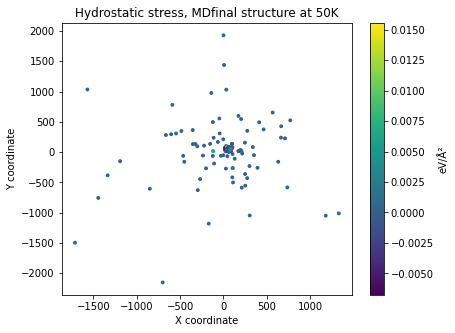

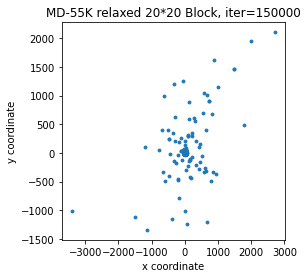

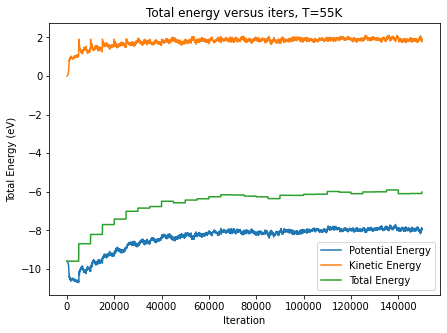

length of r array
400
begining and end of r array
1.0 12.0


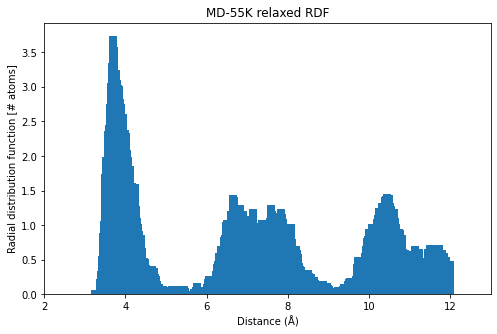

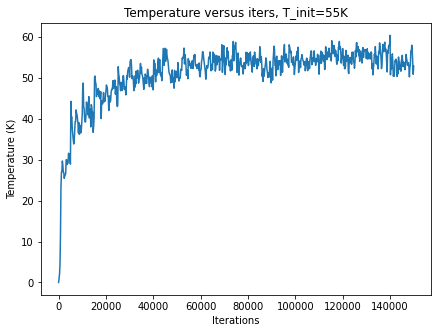

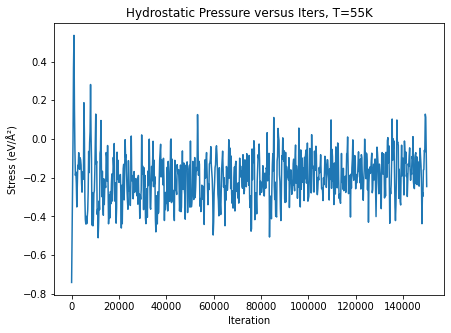

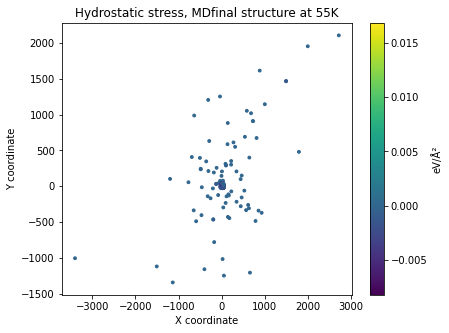

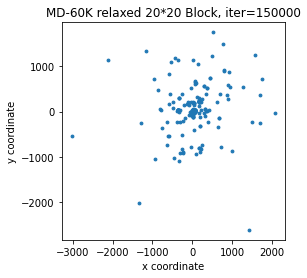

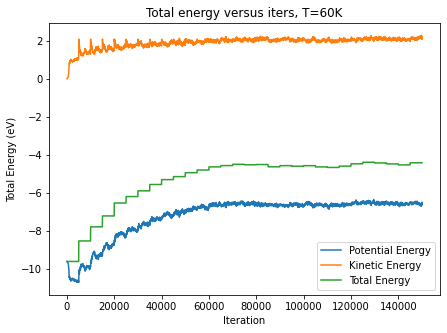

length of r array
400
begining and end of r array
1.0 12.0


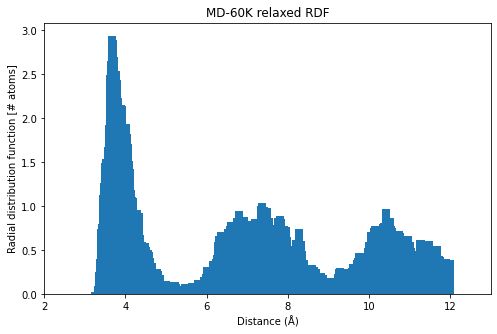

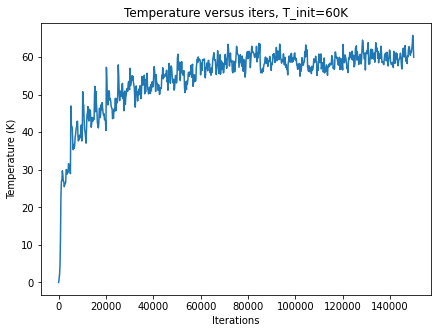

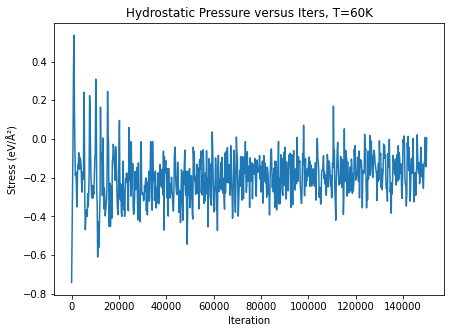

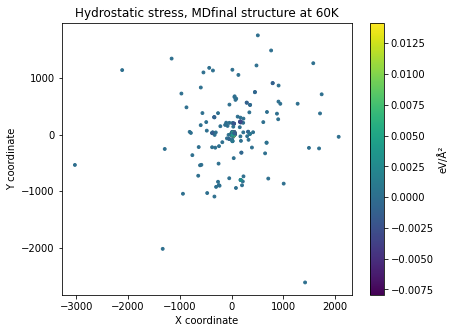

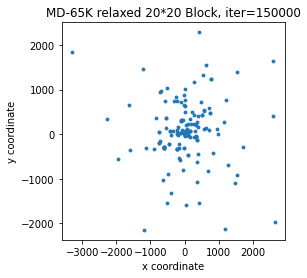

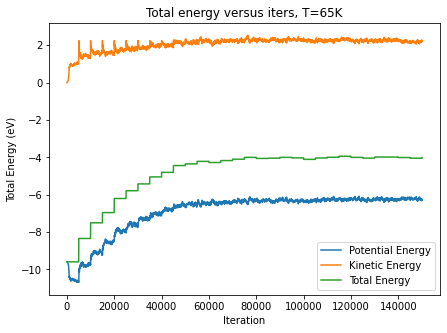

length of r array
400
begining and end of r array
1.0 12.0


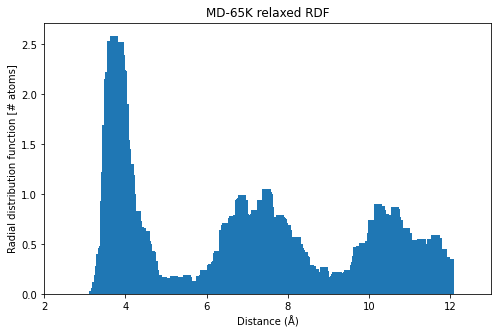

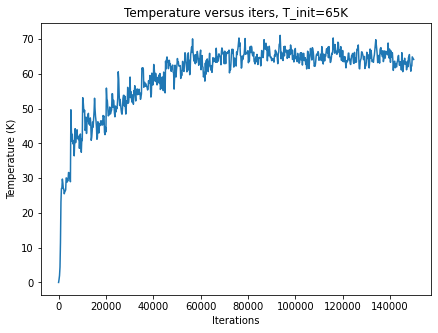

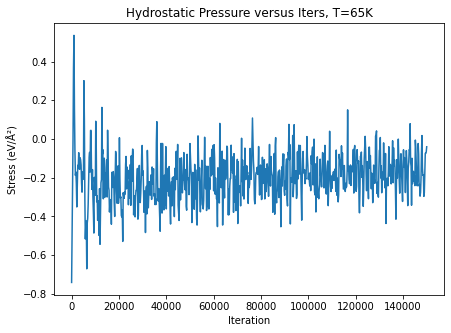

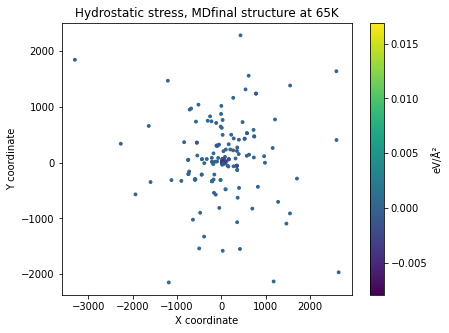

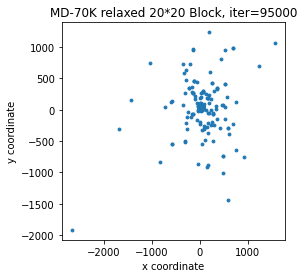

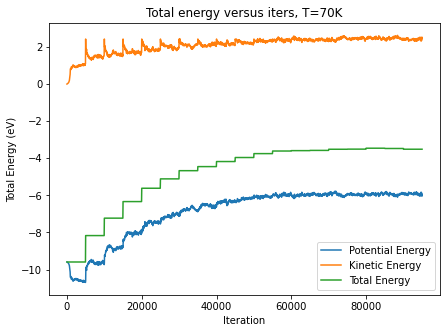

length of r array
400
begining and end of r array
1.0 12.0


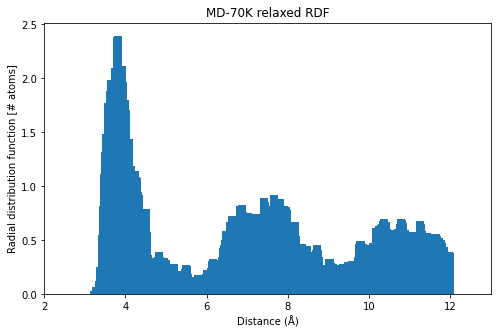

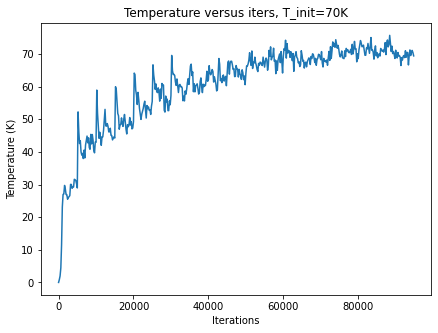

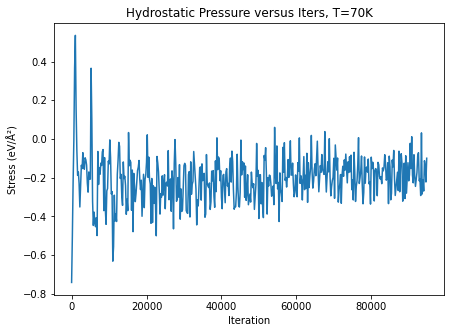

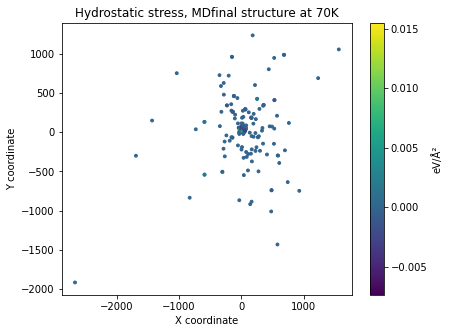

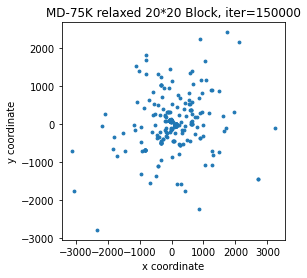

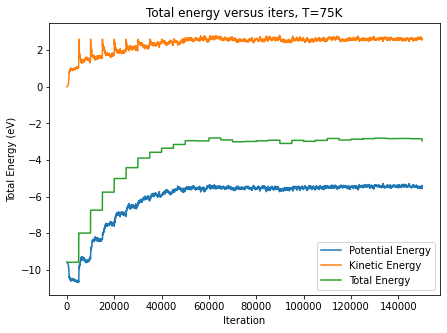

length of r array
400
begining and end of r array
1.0 12.0


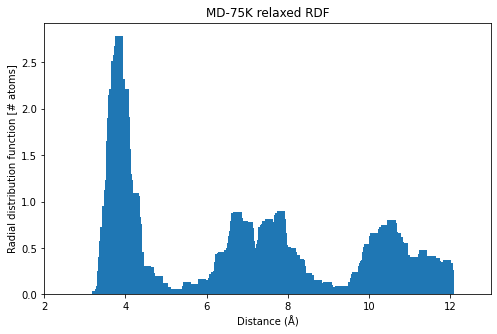

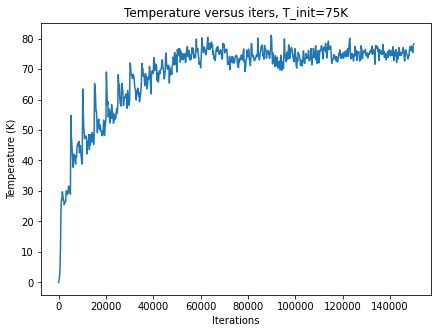

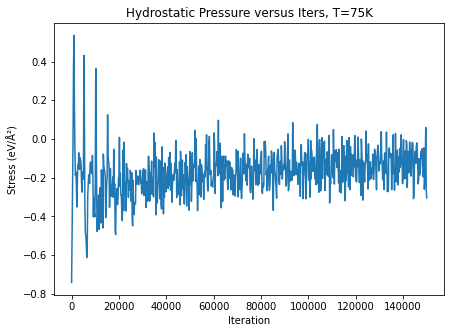

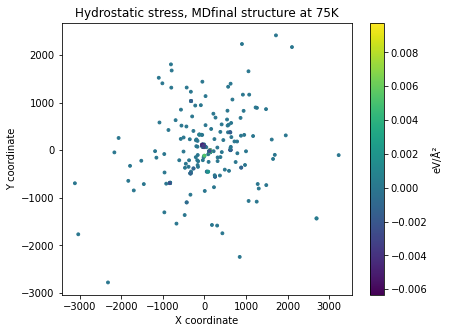

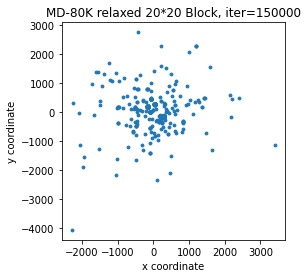

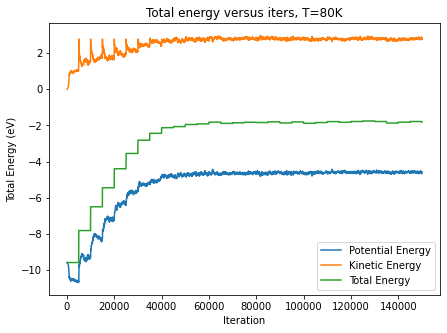

length of r array
400
begining and end of r array
1.0 12.0


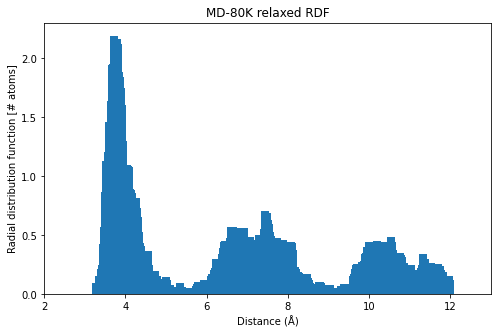

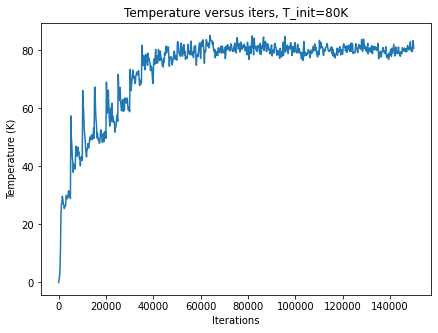

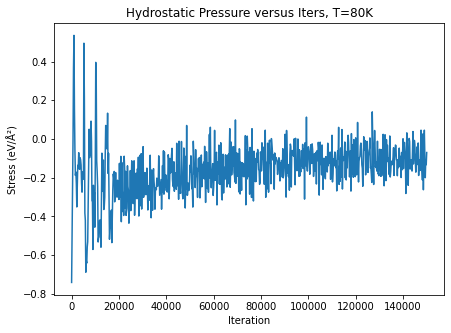

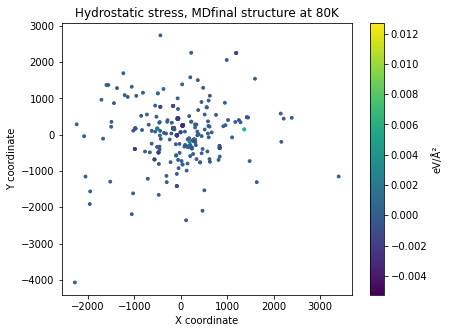

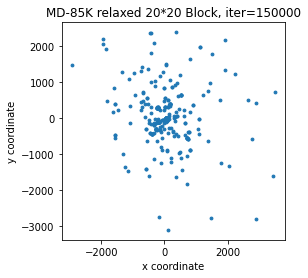

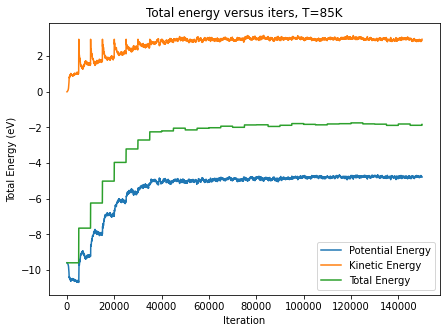

length of r array
400
begining and end of r array
1.0 12.0


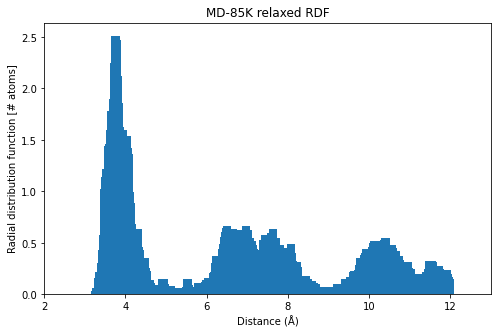

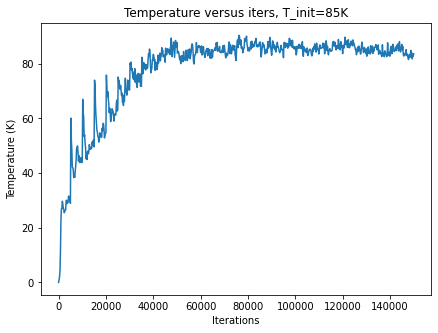

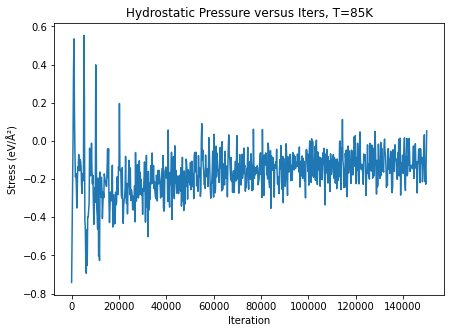

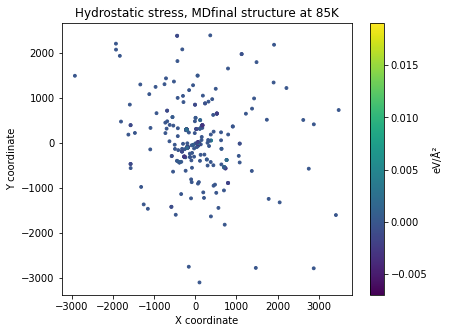

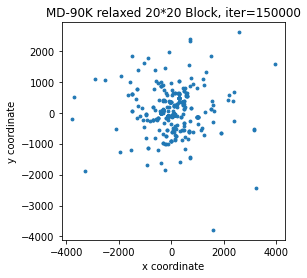

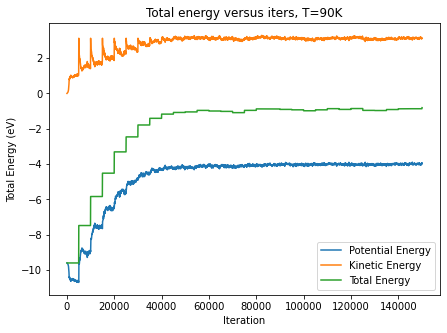

length of r array
400
begining and end of r array
1.0 12.0


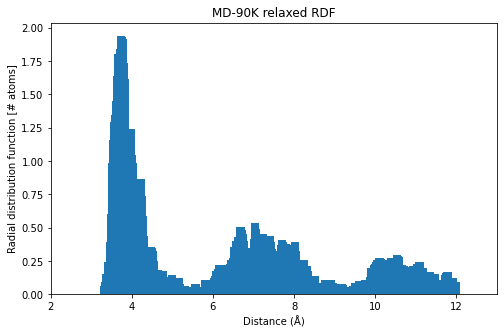

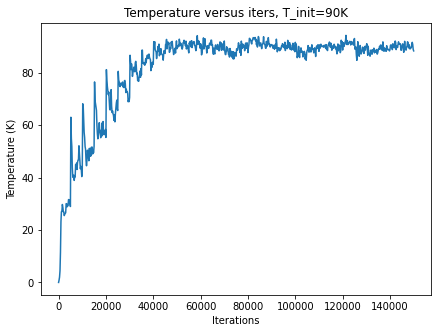

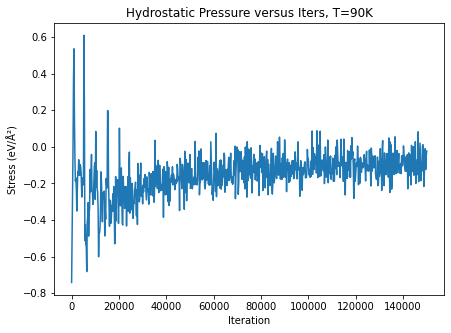

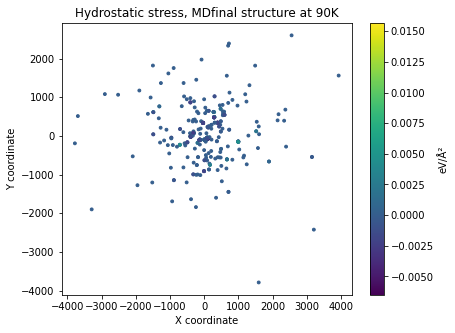

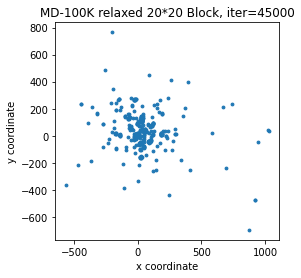

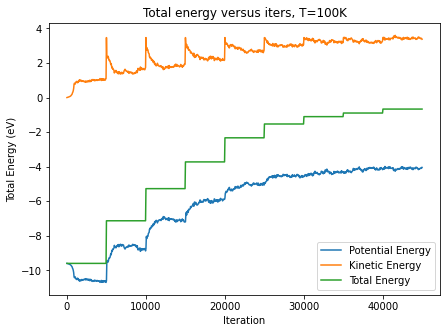

length of r array
400
begining and end of r array
1.0 12.0


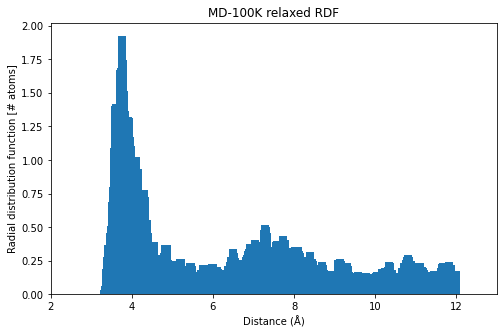

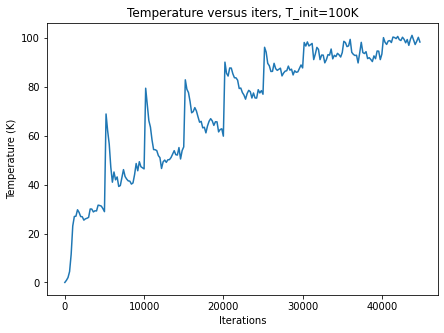

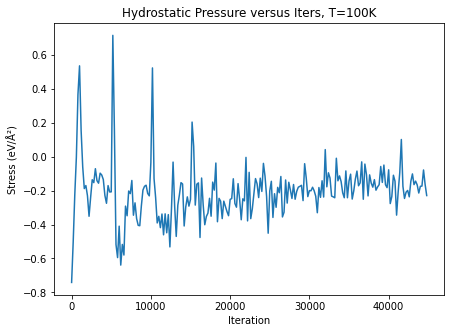

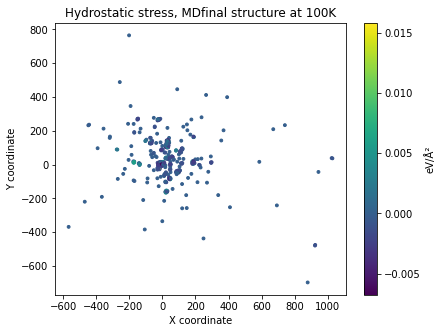

In [95]:
for i in range(len(T_list_1)):
    coords_1, E_p, E_k, hydrostress, v_J, T, stopstep = datapack_1[str(T_list_1[i])+'K']
    Plot_results(coords_1, E_p, E_k, hydrostress, T, T_list_1[i], stopstep)

### Evaluate the total energy and total hydrostatic pressure and plot their temperature dependencies. 

In [191]:
T_init_list = T_list_1
E_p_finals,E_k_finals,HS_finals,E_tot_finals,E_var_T=[],[],[],[],[]
for i in range(len(T_init_list)):
    T = T_init_list[i]
    E_p,E_k,_,HS = datapack[str(T)+'K'][1:5]
    E_tot = np.array(E_p[-1000:])+np.array(E_k[-1000:])
    E_var = np.var(E_tot)
    E_p_T,E_k_T,HS_T = E_p[-1],E_k[-1],HS[-1]
    E_tot_T = E_p_T+E_k_T
    E_p_finals.append(E_p_T)
    HS_finals.append(HS_T)
    E_tot_finals.append(E_tot_T)
    E_var_T.append(E_var)

In [178]:
def Plot_temperature_dependencies_scatter(E_x_finals,T,n=20,type='Potential',color='g'):
    """Plot the temperature dependencies of some physical parameters, 
        e.g.: potential energy (PE), kinetic energy (KE), total energy (E_t, PE+KE), hydrostatic energy (sigma_h)

    Args:
        E_x_finals (list): A list of any energy (Default: PE) value corresponds to T(T_init_list)
        T (list): Temperature list corresponds to E_x_finals.
        type (str, optional): What kind of data we want to plot versus temperature list. Defaults to 'Potential'.
        color (str, optional): Color of diagram. Defaults to 'g'(green).
    """
    plt.figure(figsize=(8,6))
    plt.scatter([i for i in T], [i for i in E_x_finals],label='Converged '+type)
    plt.plot([i for i in T], [i for i in E_x_finals],c=color,alpha=0.3)
    plt.title('Temperature dependencies of '+type+', '+str(n)+'*'+str(n)+' Block')
    plt.xlabel('Temperature (K)')
    plt.legend()
    plt.show()

In [179]:
n1=20

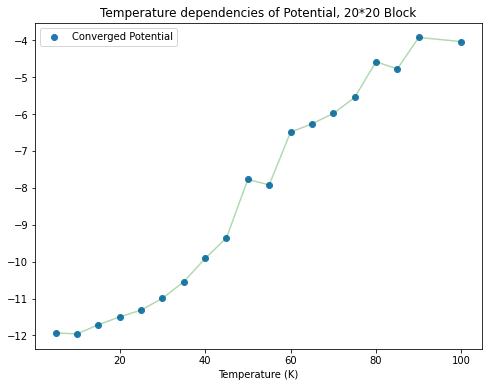

In [180]:
Plot_temperature_dependencies_scatter(E_p_finals,T_init_list,n1)

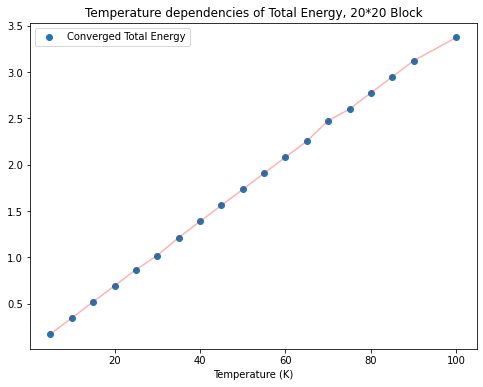

In [181]:
Plot_temperature_dependencies_scatter(E_tot_finals,T_init_list,n1,type='Total Energy',color='r')

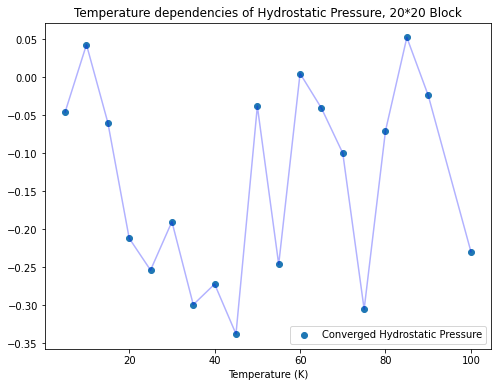

In [182]:
Plot_temperature_dependencies_scatter(HS_finals,T_init_list,n1,'Hydrostatic Pressure',color='b')

## 3. Relevant specific heat
#### *Determine the temperature dependence of the relevant specific heat*

#### According to the definition, with a constant volume:
$$
C_v = (\frac{dE}{dT})_v
$$

In [183]:
def C_v(E_list,T_list):
    """Relevant specific heat at constant volume.

    Args:
        E_list (list): Energy values corresponding to temperature list.
        T_list (list): Temperature list corresponding to energy values.

    Returns:
        Array: Relevant heat corresponding to temperature list. (len(T_list),)
    """
    C_v_list = []
    for i in range(len(E_list)-1):
        dE = E_list[i+1] - E_list[i]
        dT = T_list[i+1] - T_list[i]
        dE_dT = dE/dT
        T = T_list[i] + dT/2
        C_v_list.append(np.array([dE_dT,T]))
    return np.array(C_v_list).T

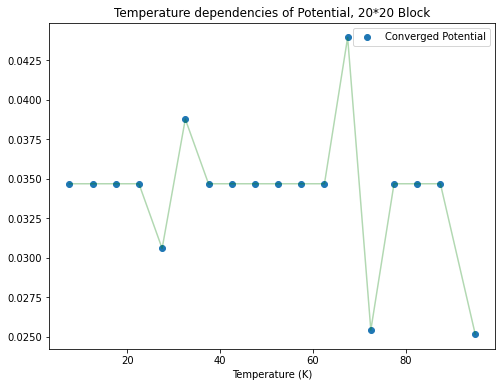

In [189]:
C_v_array = C_v(E_tot_finals,T_init_list)
c1,c2=C_v_array
Plot_temperature_dependencies_scatter(c1,c2,n=20,type='Potential',color='g')

From the diagram above, it is quite clear that around 35K and 65K there are two peaks, which are the predicted melting and boiling point of 2D Argon, respectively.

#### Or, according to the theory of fluctuatins 
in Stat Mech, corresponding to Vitek's notes expression (MD33):
$$
C_v = \frac{<E^2>-<E>^2}{k_BT}
$$
It is only appropriate when the $\textbf{ambient temperature}$ remains rigorously $\textbf{constant}$. Although it may not seem suitable for our molecular dynamics (MD) work, I included it here for the sake of completeness.

In [ ]:
def C_v_1(E_var, T_list, K_B=8.67*10**(-5)):
    """Relevant specific heat at constant Temperature..

    Args:
        E_var (list): Variance of energy of the system corresponding to temperature list, eV.
        T_list (list): Temperature list corresponding to energy values, Kelvin.
        K_B(float, optional): Boltzmann parameter, eV/K. Defaults to 8.67*10**(-5)

    Returns:
        Array: Relevant heat corresponding to temperature list. (len(T_list),)
    """
    c1 = E_var
    c2 = (K_B*np.array(T_list)**2)
    return c1/c2

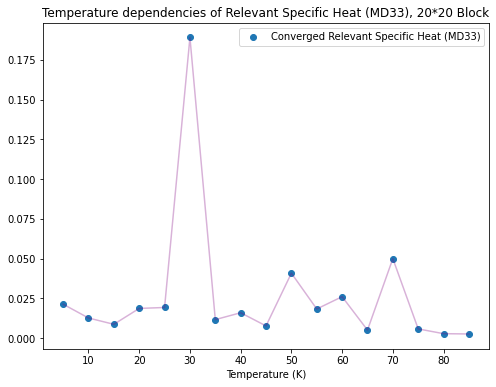

In [ ]:
C_v_1_array = C_v_1(E_var_T, E_tot_finals, T_list_1)
Plot_temperature_dependencies_scatter(C_v_1_array[:-2],T_list_1[:-2],n1,'Relevant Specific Heat (MD33)',color='purple')

According to MD33 equation, around 30K and 70K there are two peaks as the predicted melting and boiling point of 2D Argon, respectively.

## 4. Autocorrelation Function
#### *Determine the autocorrelation function of velocities for various temperatures*

### Run 2000 further iterations to get the Autocorrelation data

In [128]:
def further_loop(coords,v_J,delta_t=5e-15,iter_num=1000):
    """Run further iterations to get the Autocorrelation data

    Args:
        coords (numpy.ndarray): Final coordinate array from mainloop, initial coordinate array of further loop, (400,2)
        v_J (numpy.ndarray): Final velocity array from mainloop, initial velocity array of further loop, (400,2)
        delta_t (float, optional): Differential time quantity, second(s). Defaults to 5e-15.
        iter_num (int, optional): How many iters further carrying out. Defaults to 1000.

    Returns:
        v_log (numpy.ndarray): 3-dimensional velocity array, (iteration_num,num_of_atom,system_dimension)=(1000,20*20,2)
        coords_J_1 (numpy.ndarray): Final coordinate after further loop, (400,2)
    """
    
    # Initialize lists for plotting
    v_log = list()

    # Initialize variable for optimising

    # Initial position(400,2), vector(400,2) and systemforce(1,2)
    coords_J_1 = coords.copy()
    v_J_1 = v_J.copy()
    force_J_1 = force_arr(coords_J_1)


    for iter in trange(iter_num+1):

        coords_J = coords_J_1.copy()  # positions of 400 atoms at JΔt
        force_J = force_J_1.copy()  # forces of of 400 atoms at JΔt
        v_J = v_J_1  # velocities of of 400 atoms at JΔt

        # Update the position array, coords_J.shape=(400,2), force_J.shape=(1,2)
        # According to r_i(J+1) = r_i(J) + (dt/2m)*(F_i(J+1)+F_i(J))
        coords_J_1 = update_position_vectorize(coords_J,force_J,v_J,delta_t,m=6.63*1e-26)

        # Update the force array, force_J.shape=(1,2)
        force_J_1 = force_arr(coords_J_1)

        # Update the velocity array, v.shape=(400,2), v_i.shape=(1,2)
        # According to v_i(J+1) = v_i(J) + (dt/2m)*(F_i(J+1)+F_i(J))
        v_J_1 = update_velocity_vectorize(force_J,force_J_1,v_J,delta_t,m=6.63*1e-26)

        v_log.append(v_J_1.copy())  # v_J_1: (400,2), v_log: (1000,400,2)

    return np.array(v_log), coords_J_1

In [131]:
def collect_data_for_acf(T,dt=5e-15,iter_num=1000):
    """Choose the temperature we want to collect acf data.

    Args:
        T (int): Temperature we want to collect acf data.
        dt (float, optional): Differential value of time, second. Defaults to 5e-15.
        iter_num (int, optional): Number of iteration. Defaults to 1000.

    Returns:
        v_J_versus_t(numpy.ndarray): total velocity of the system for each time interval (dt).
        coords(numpy.ndarray): Final locations of each atom, (400,2)
    """
    # Collect coords&v_J arrays at every timestep
    # Read already-relaxed atom positions (400,2) and latest v_J (400,2)
    coords, _, _, _, v_J, _, _ = datapack[str(T)+'K']

    # Collect data from further loop, v_J_versus_t: (1000,400,2)
    v_J_versus_t,coords = further_loop(coords,v_J,dt,iter_num)
    
    return v_J_versus_t,coords

In [132]:
v_log_coords_dict = {}
for i in range(len(T_init_list)):
    v_log_coords_dict[str(T_init_list[i])+'K'] = collect_data_for_acf(T_init_list[i])

100%|██████████| 1001/1001 [00:01<00:00, 976.72it/s]


In [133]:
len(v_log_coords_dict)

19

### Define autocorreation function

The definition of autocorrelation value is$$
AC = \sum_{j=1}^{M} C(j) = \sum_{j=1}^{M} <v(j-1)\cdot v(j-1+t)>
$$
For one certain $j=0$, $M=\frac{(further\_iter\_num)}{2}=500,$ the addend of AC, $C(j=0)$ can be written as:
$$ C(0) =  <v(0) \cdot v(t)> =\frac{1}{M}[v(1)v(1+t)+v(2)v(2+t)+...+v(M)v(M+t)]  $$
Generalize to any j, we have:
$$ C(j) = <v(j) \cdot v(j+t)> =\frac{1}{M}[v(j+1)v(j+1+t)+v(j+2)v(j+2+t)+...+v(j+M)v(j+M+t)]  $$

In [134]:
def ACF(v_J_versus_t,iter_num=1000):
    """Autocorrelation function. Calculating by using the further iterations after main loop.

    Args:
        v_J_versus_t (numpy.ndarray): Final 3-dimensional velocity array after further-loop, (iteration_num,num_of_atom,system_dimension)=(1000,20*20,2)

    Returns:
        tlist: continuous number of timestep, i.e.:1,2,3,...(int(iter_num/2))
        ac: autocorrelation value. i.e.:<v(0)v(t)>
    """

    # Figure out <v(t)>s, i.e. <v(0)>~<v(1000)>
    # v_t_i.shape=(1000,400)
    v_t_i = np.sqrt(np.sum(v_J_versus_t**2,axis=2))
    ttt = int(len(v_J_versus_t)/2)  # ttt=500
    M = len(v_J_versus_t)-ttt
    tlist,ac=[],[]
    for t in trange(1,ttt+1):
        # <v(0)v(t)> =c =1/M*[v(1)v(1+t)+v(2)v(2+t)+...+v(M)v(M+t)]
        c = 0
        for j in range(M):
            # c.shape=(400,)
            c += (v_t_i[j] * v_t_i[j+t])  # c_j= v(1)v(1+t),v(2)v(2+t),...,v(M)v(M+t)
        c = np.sum(c)/(M*400)  # c is scalar
        # ac =[<v(0)v(t)>,<v(1)v(t+1)>,<v(2)v(t+2)>,...,<v(1000-t)v(1000)>]
        ac.append(c)
        tlist.append(t)
    return tlist,ac
    

In [136]:
acf_results = {}
for i in range(len(T_init_list)):
    v_J_versus_t,coords = v_log_coords_dict[str(T_init_list[i])+'K']
    acf_results[str(T_init_list[i])+'K'] = ACF(v_J_versus_t)

100%|██████████| 500/500 [00:00<00:00, 1111.79it/s]


### Plot ACF Temperature dependence

In [137]:
def plot_acf(acf_result,T,dt=1e-14):
    """Plot ACF versus a series of temperature.

    Args:
        acf_result (dict): A dictionary recording ACF results. e.g.: acf_result['10K']=(tlist,ac) 
        T (list): Temperature list, as the T_desire of certain ACF-iteration plot.
        dt (float, optional): Timestep, second(s). Defaults to 1e-14.
    """
    tlist,ac = acf_result
    # Plot the temperature dependence
    plt.figure(figsize=(8,6))
    plt.plot(tlist,ac,alpha=0.6)
    plt.title('Autocorrelation Function at '+str(T)+'K')
    plt.xlabel('Time ('+str(dt)+' second)')
    plt.ylabel('Velocity correlation function')
    plt.show()

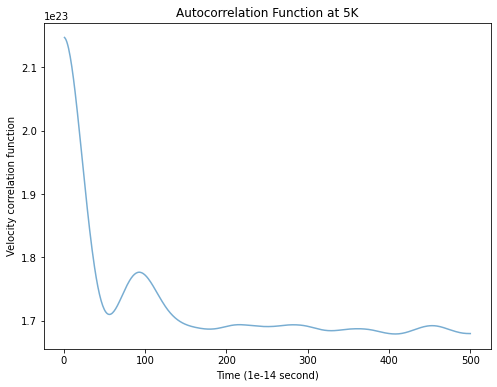

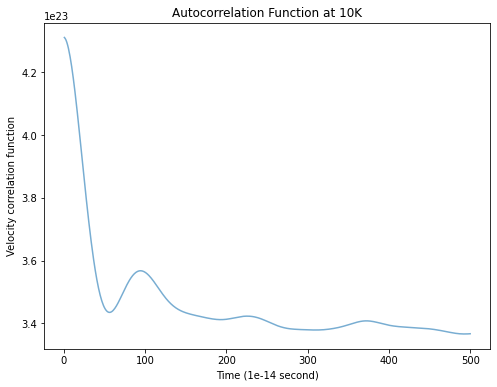

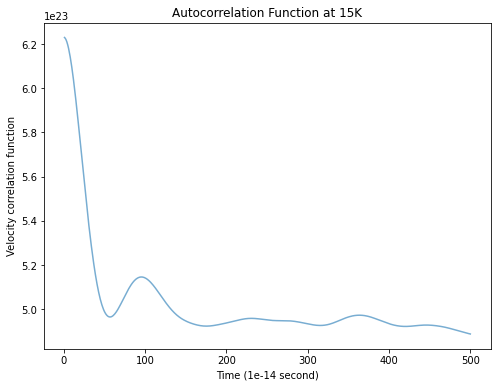

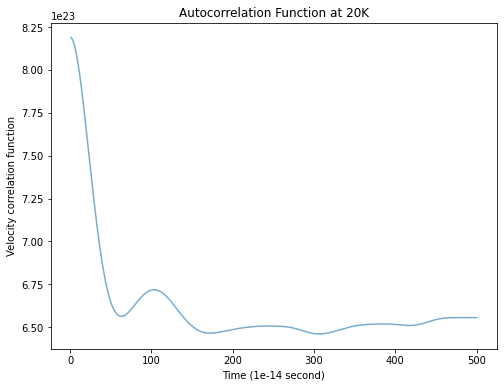

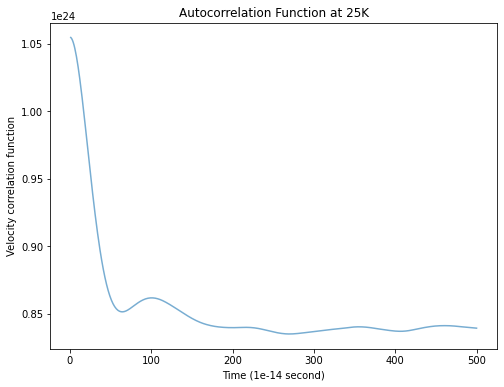

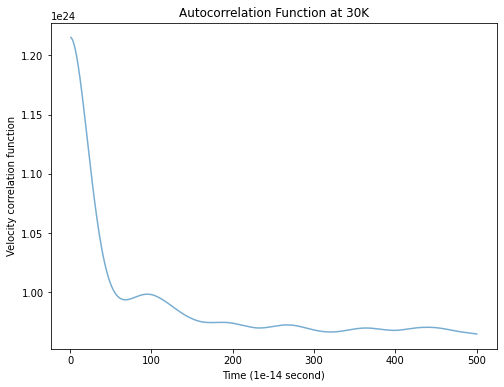

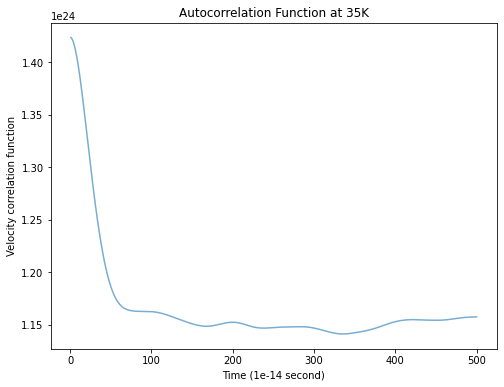

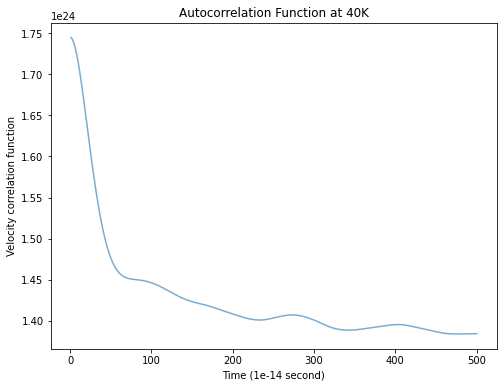

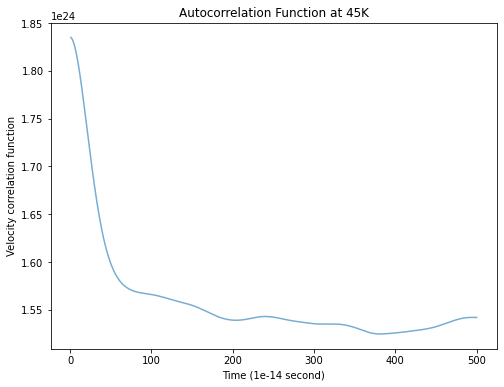

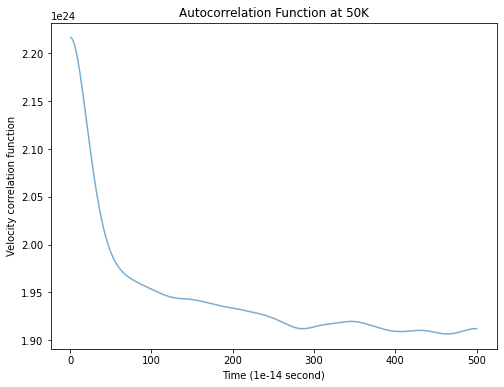

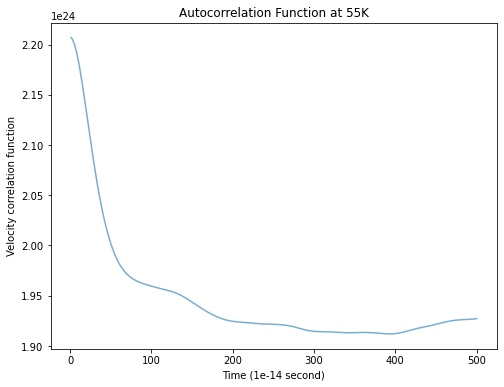

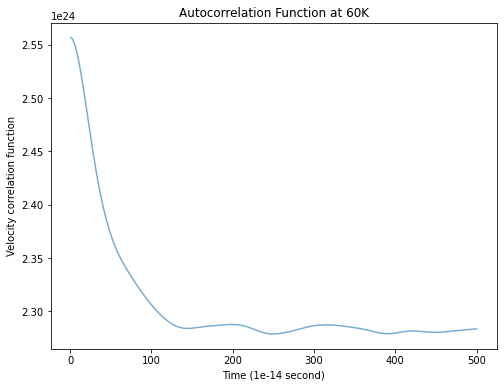

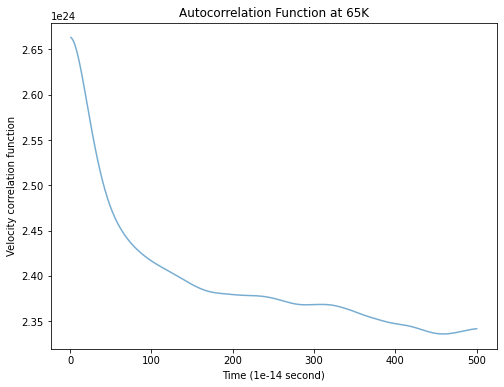

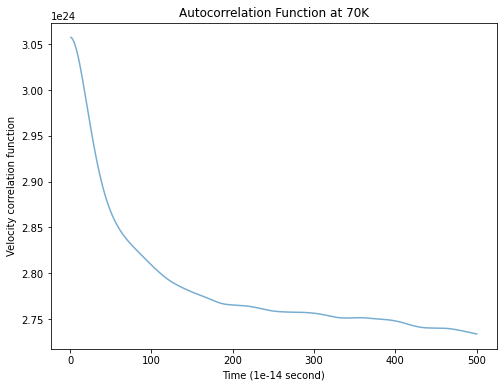

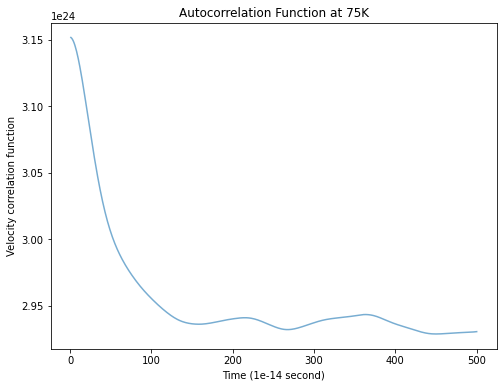

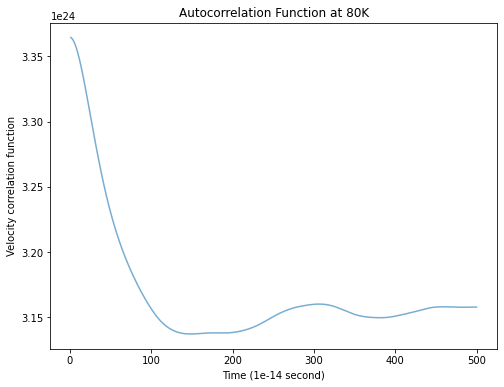

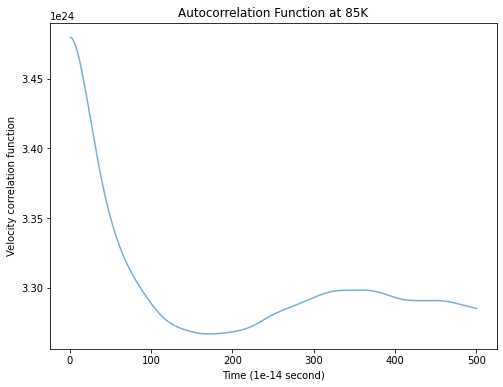

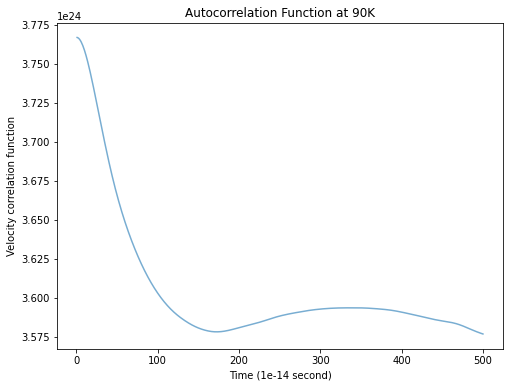

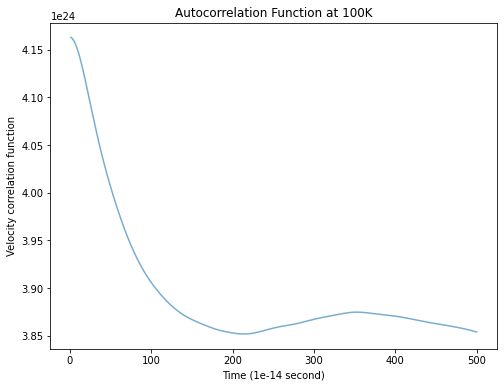

In [138]:
dt = 1e-14
for i in range(len(T_init_list)):
    plot_acf(acf_results[str(T_init_list[i])+'K'],T_init_list[i],dt)

## 5. Self-diffusion Coefficient
#### *Plot ln(D) vs 1/T for T up to 100 K and comment on the meaning of the slope.*

The evaluation of self-diffusion coefficient from acf is as:
$$ D = \lim_{ \tau \to \infty} \frac{1}{6\tau}<[\textbf{r}(\tau) - \textbf{r}(0)]^{2}>
$$
Here, we give an approximate calculation let $\tau=500$, i.e.:
$$ D= \frac{1}{3} \sum_{i}^{\tau=500}Acf(T)
$$

In [139]:
def D_T(T_list,ACF_results,dt=1e-14):
    """Function of D(T)

    Args:
        T_list (int list): Series of ambient (desired) temperature, kelvin.
        acf_results (dict): recorded the acf results for each temperature, 
            i.e.: for 10K, ac_list = acf_results['10K']
        dt (float, optional): timestep. Defaults to 1e-14.

    Returns:
        list: self-diffusion coefficient list corresponds to the T_list
    """
    D = []
    for i in range(len(T_list)):
        _,ac_list = ACF_results[str(T_init_list[i])+'K']
        ac = np.array(ac_list)
        D.append(1/3*np.sum(ac*dt))
    return D

In [140]:
def plot_D_T(T_list,D_list):
    """Plot the relationship between log{self-diffusion coefficient (D)} and reciprocal{ambient temperature(T)}
        i.e.: log(D) versus (1/T)

    Args:
        T_list (int list): Series of ambient (desired) temperature, kelvin
        D_list (float list): Corresponding self-diffusion coefficient value
    """
    lnD = np.log(D_list[1:])
    T_reciprocal = 1/np.array(T_list[1:])
    plt.scatter(T_reciprocal,lnD)
    plt.plot(T_reciprocal,lnD,alpha=0.6)
    plt.xlabel('T⁻¹ (1/K)')
    plt.ylabel('ln(D)')
    plt.title('Diffusion Coefficient Function')
    plt.show()

In [142]:
D_list = D_T(T_init_list,acf_results)

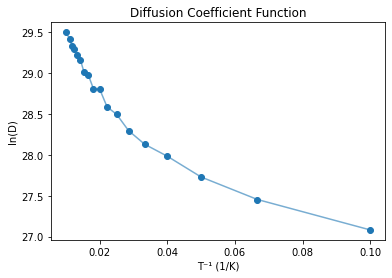

In [146]:
plot_D_T(T_init_list,D_list)

Exempting the points far away from the melting points, we got the stright line (linear relationship) as follows:

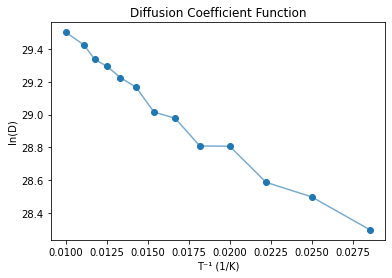

In [150]:
plot_D_T(T_init_list[5:],D_list[5:])